# Estudo da Fotocorrente e Absorção em Heteroestruturas Semicondutora


## Bibliotecas utilizadas

In [1]:
# python standard
import os
import time
import re
from multiprocessing import Pool, TimeoutError
from datetime import datetime

#third-party
import numpy as np
import pandas as pd
from scipy.integrate import simps

# locals
from core.constantes import *
from core.utilidades import *
from core.potencial_degani import *

## Configurações gráficas

In [2]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('mestrado')

# Fotocorrente

## Constantes e definições

In [3]:
# dataframe de pandas com valores utilizados para calculos
device = pd.DataFrame()

# parâmetros gerais
N = 1024  # tamanho padrao do grid
L = 1000.0  # tamanho padrao do sistema em angstrom
dt = 1e-17  # incremento de tempo padrao em segundos
dt_au = dt / au_t # incremento de tempo padrao em unidades atômicas

# bias ou diferença de potencial
bias = 5.0  # KV/cm LIGAR NO CASO DE FOTOCORRENTE
bias_v_cm = bias * 1e3
bias_v_m = 1e2 * bias_v_cm
bias_j_m = bias_v_m * q

device['z_ang'] = np.linspace(-L/2, L/2, N)  # malha espacial em angstrom
device['x'] = device['z_ang'].apply(x_shape) # fração de alumínio
device['v_ev'] = device['x'].apply(algaas_gap) # potencial em eV
device['meff'] = device['x'].apply(algaas_meff) # massa efetiva em cada ponto

## Perfil do potencial

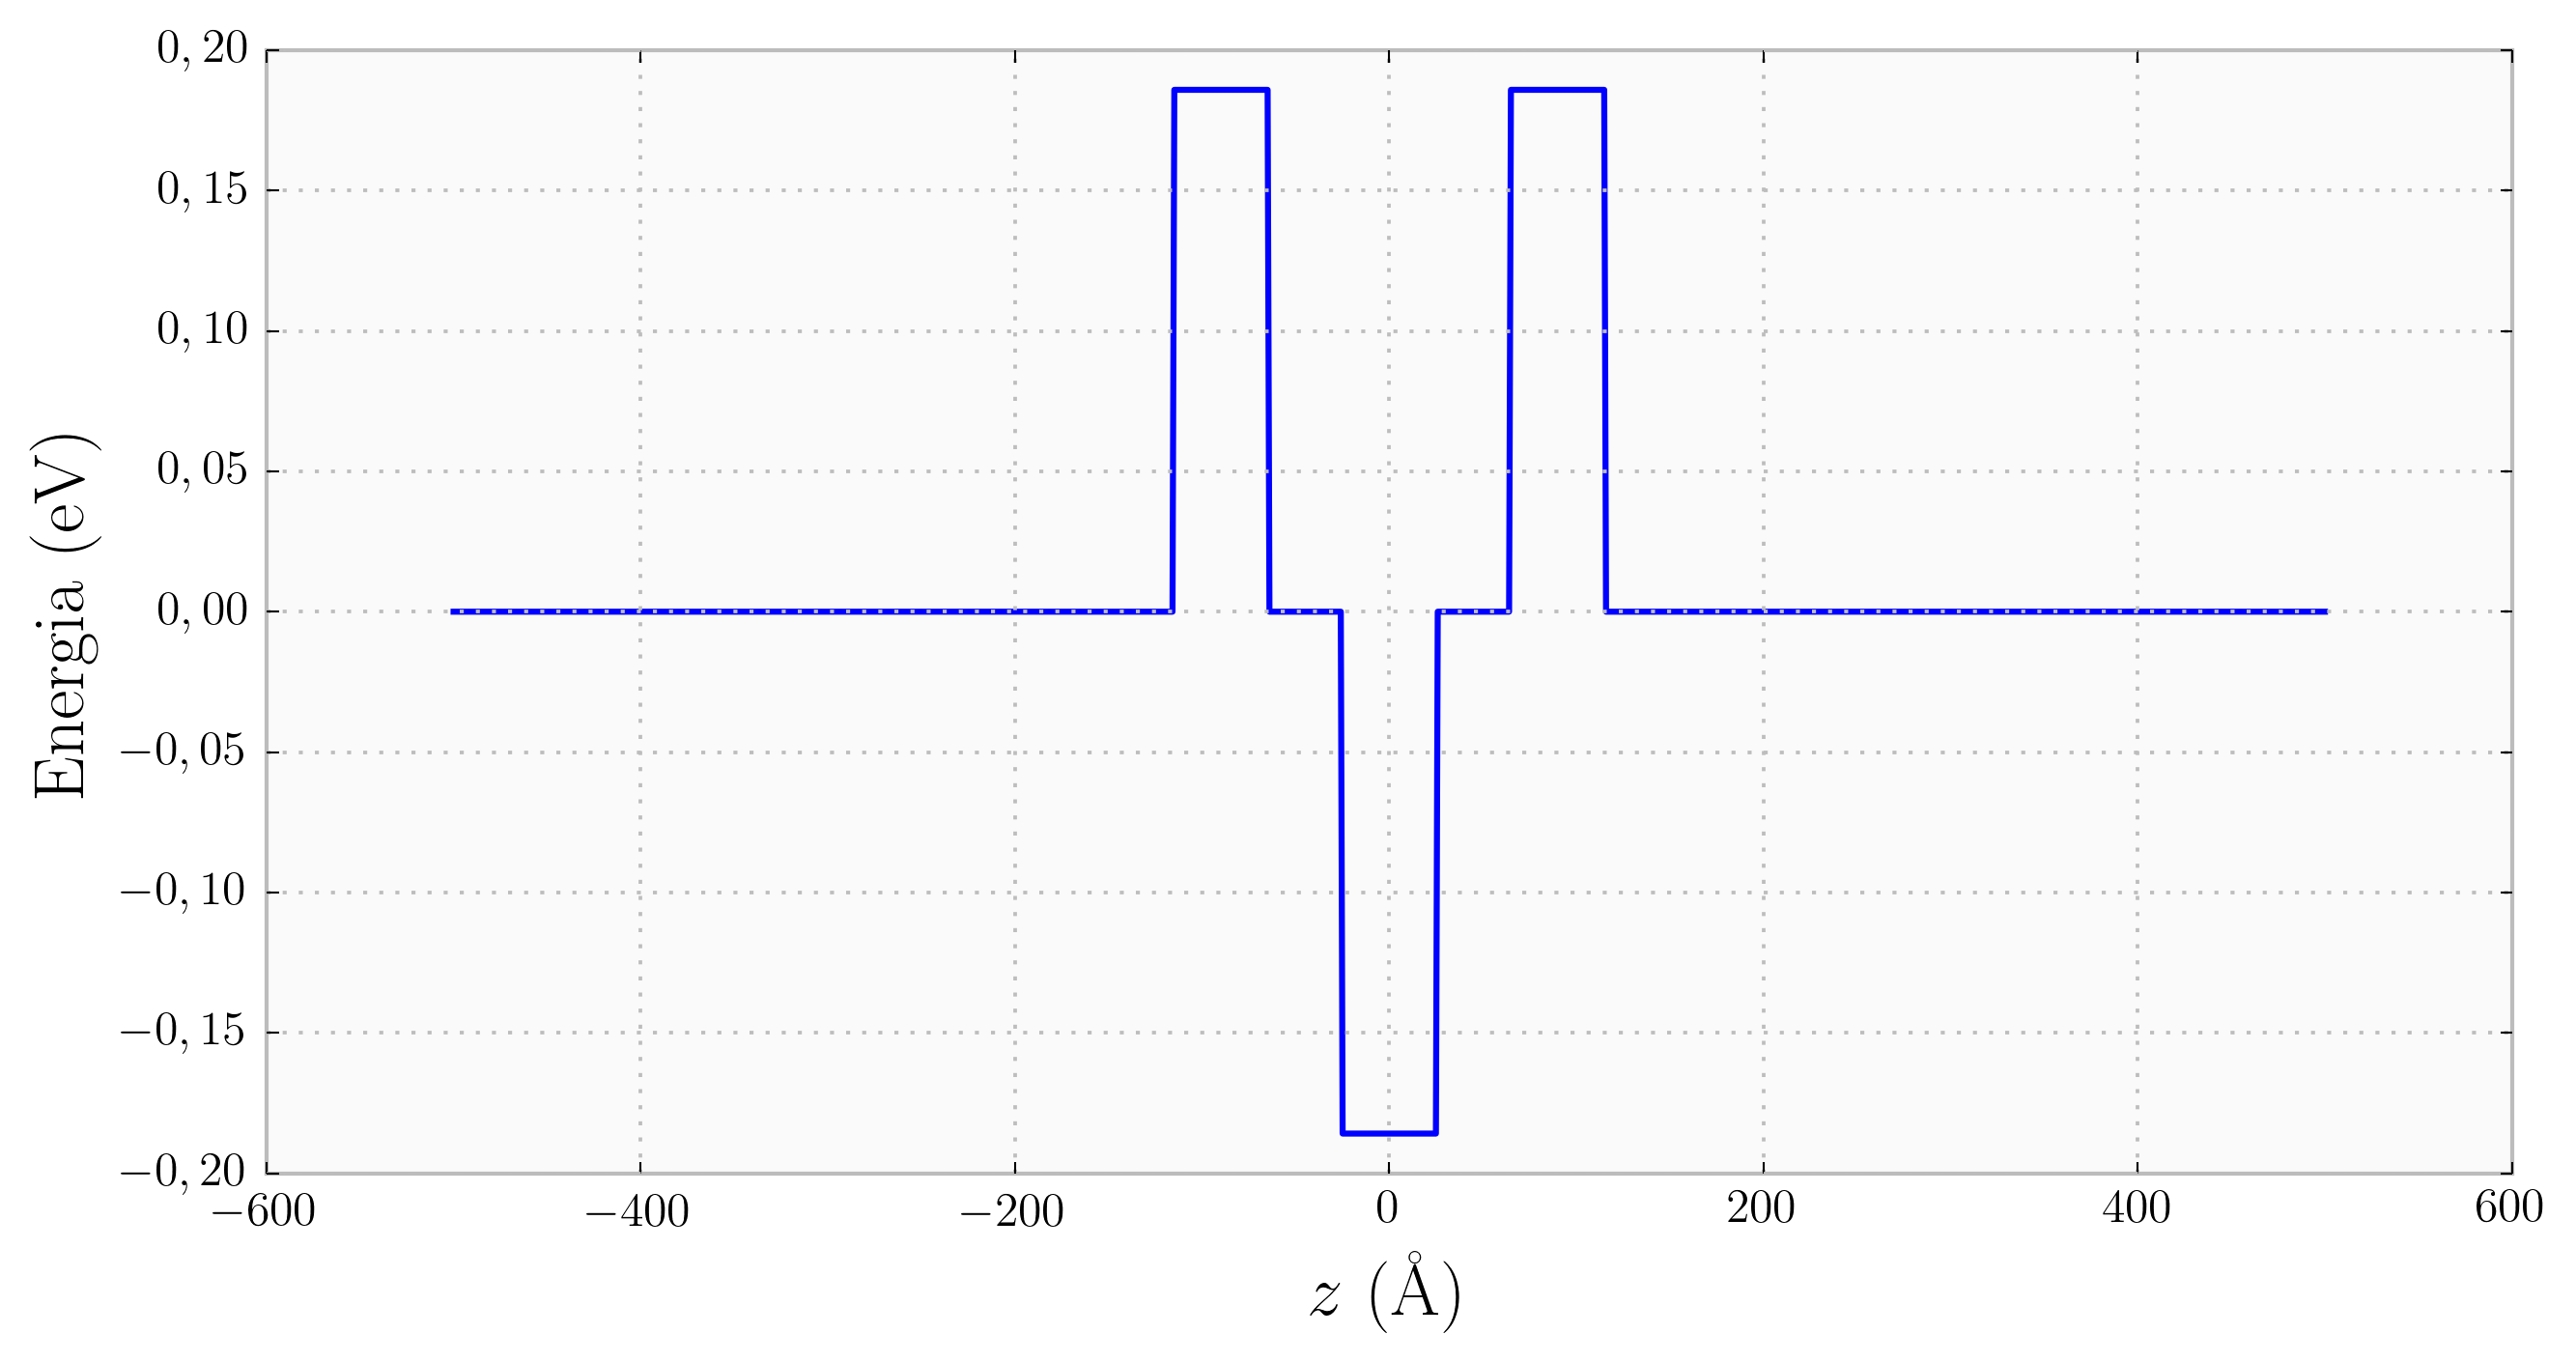

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
ax.plot(device.z_ang, device.v_ev)
plt.savefig('figuras/potencial_poco_dupla_barreira_simples.png', bbox_inches='tight')

## Aplicando o campo estático

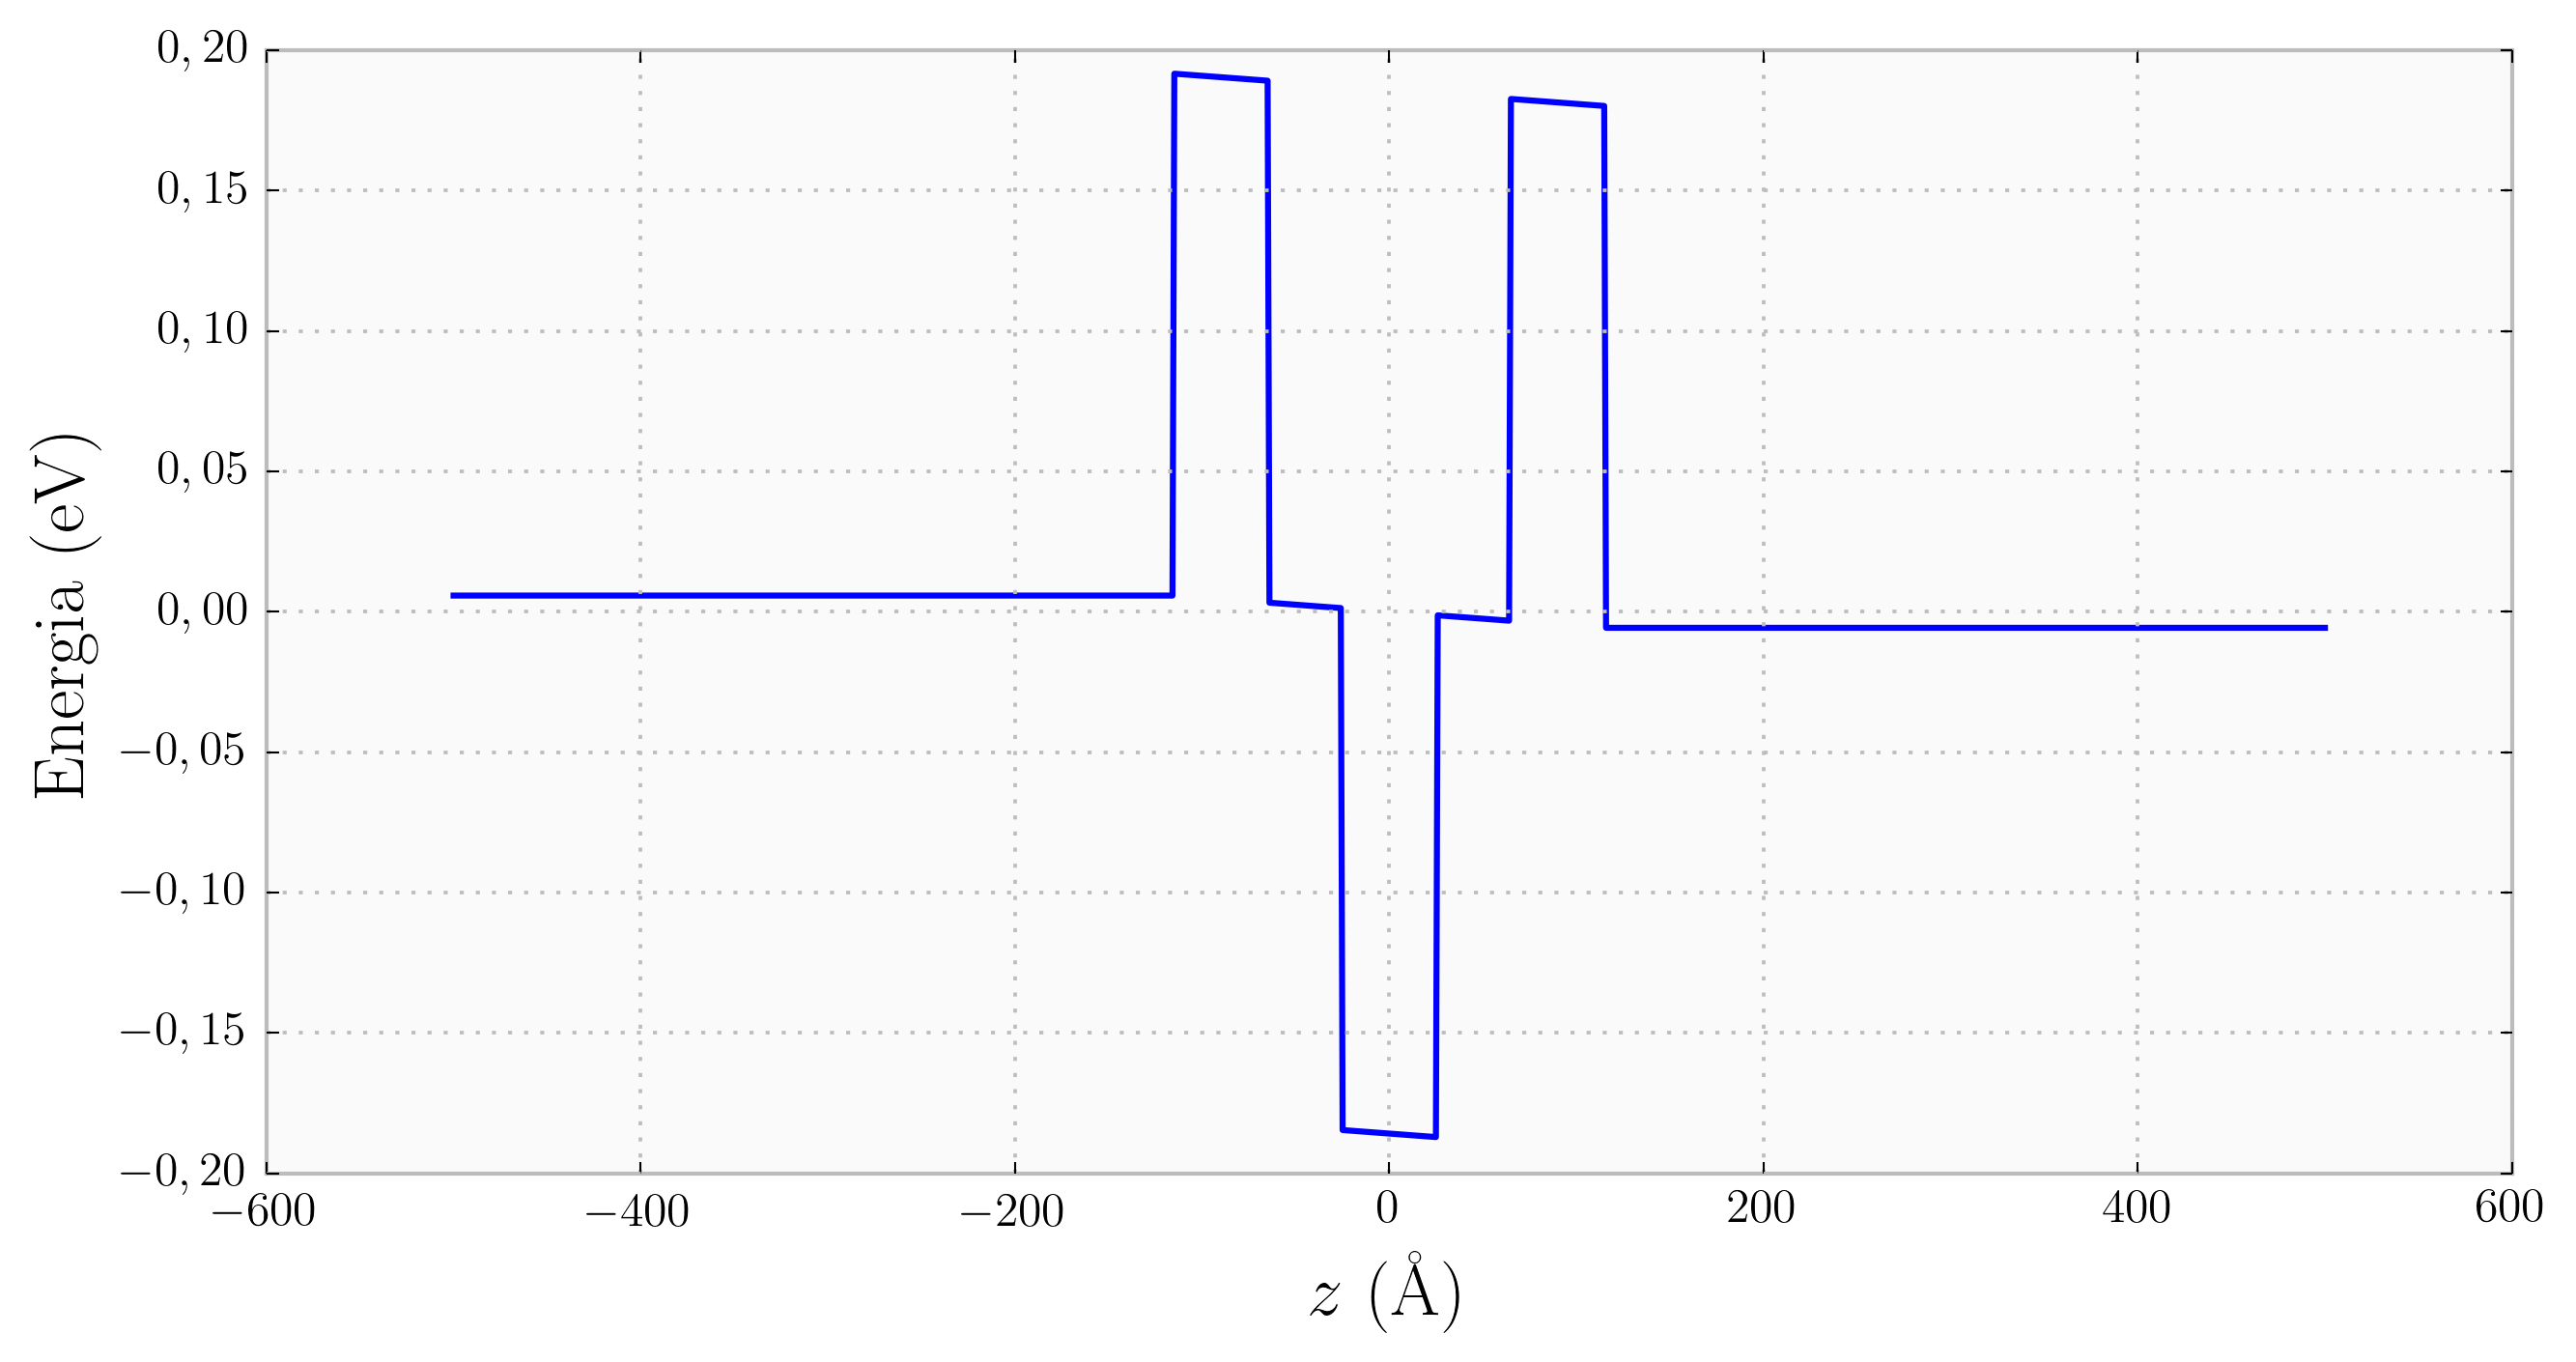

In [5]:
pb = list(device['v_ev']).index(0.185897)  # pontos antes do dispositivo
pa = N-1-pb  # pontos depois do dispositivo

def __constroi_bias(z):
    """
    constroi o potencial estatico usado como bias/vies
    NÃO USAR FORA DESTA CÉLULA
    """
    border_left = device['z_ang'].values[pb]
    border_right = device['z_ang'].values[pa]
    def f_st_ev(z): return - z * 1e-10 * bias_j_m / ev
    if z <= border_left:
        return f_st_ev(border_left)
    elif z >= border_right:
        return f_st_ev(border_right)
    return f_st_ev(z)

device['bias_ev'] = device['z_ang'].apply(__constroi_bias)
device['v_st_ev'] = device['v_ev']+device['bias_ev']

# já replica para os valores em unidades atômicas
device['z_au'] = device['z_ang'].apply(lambda z: z / au2ang)
device['v_au'] = device['v_st_ev'].apply(lambda z: z / au2ev)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
ax.plot(device.z_ang, device.v_st_ev)
plt.savefig('figuras/potencial_poco_dupla_barreira_com_bias.png', bbox_inches='tight')

## Calculando Autovalores e Autovetores

Vamos utilizar o método da interação inversa para gerar os autovalores e autovetores.

In [6]:
z = device.z_au.values
V = device.v_au.values
m = device.meff.values
vpp = np.ptp(device.v_ev)
res = interacao_inversa(z, V, m)

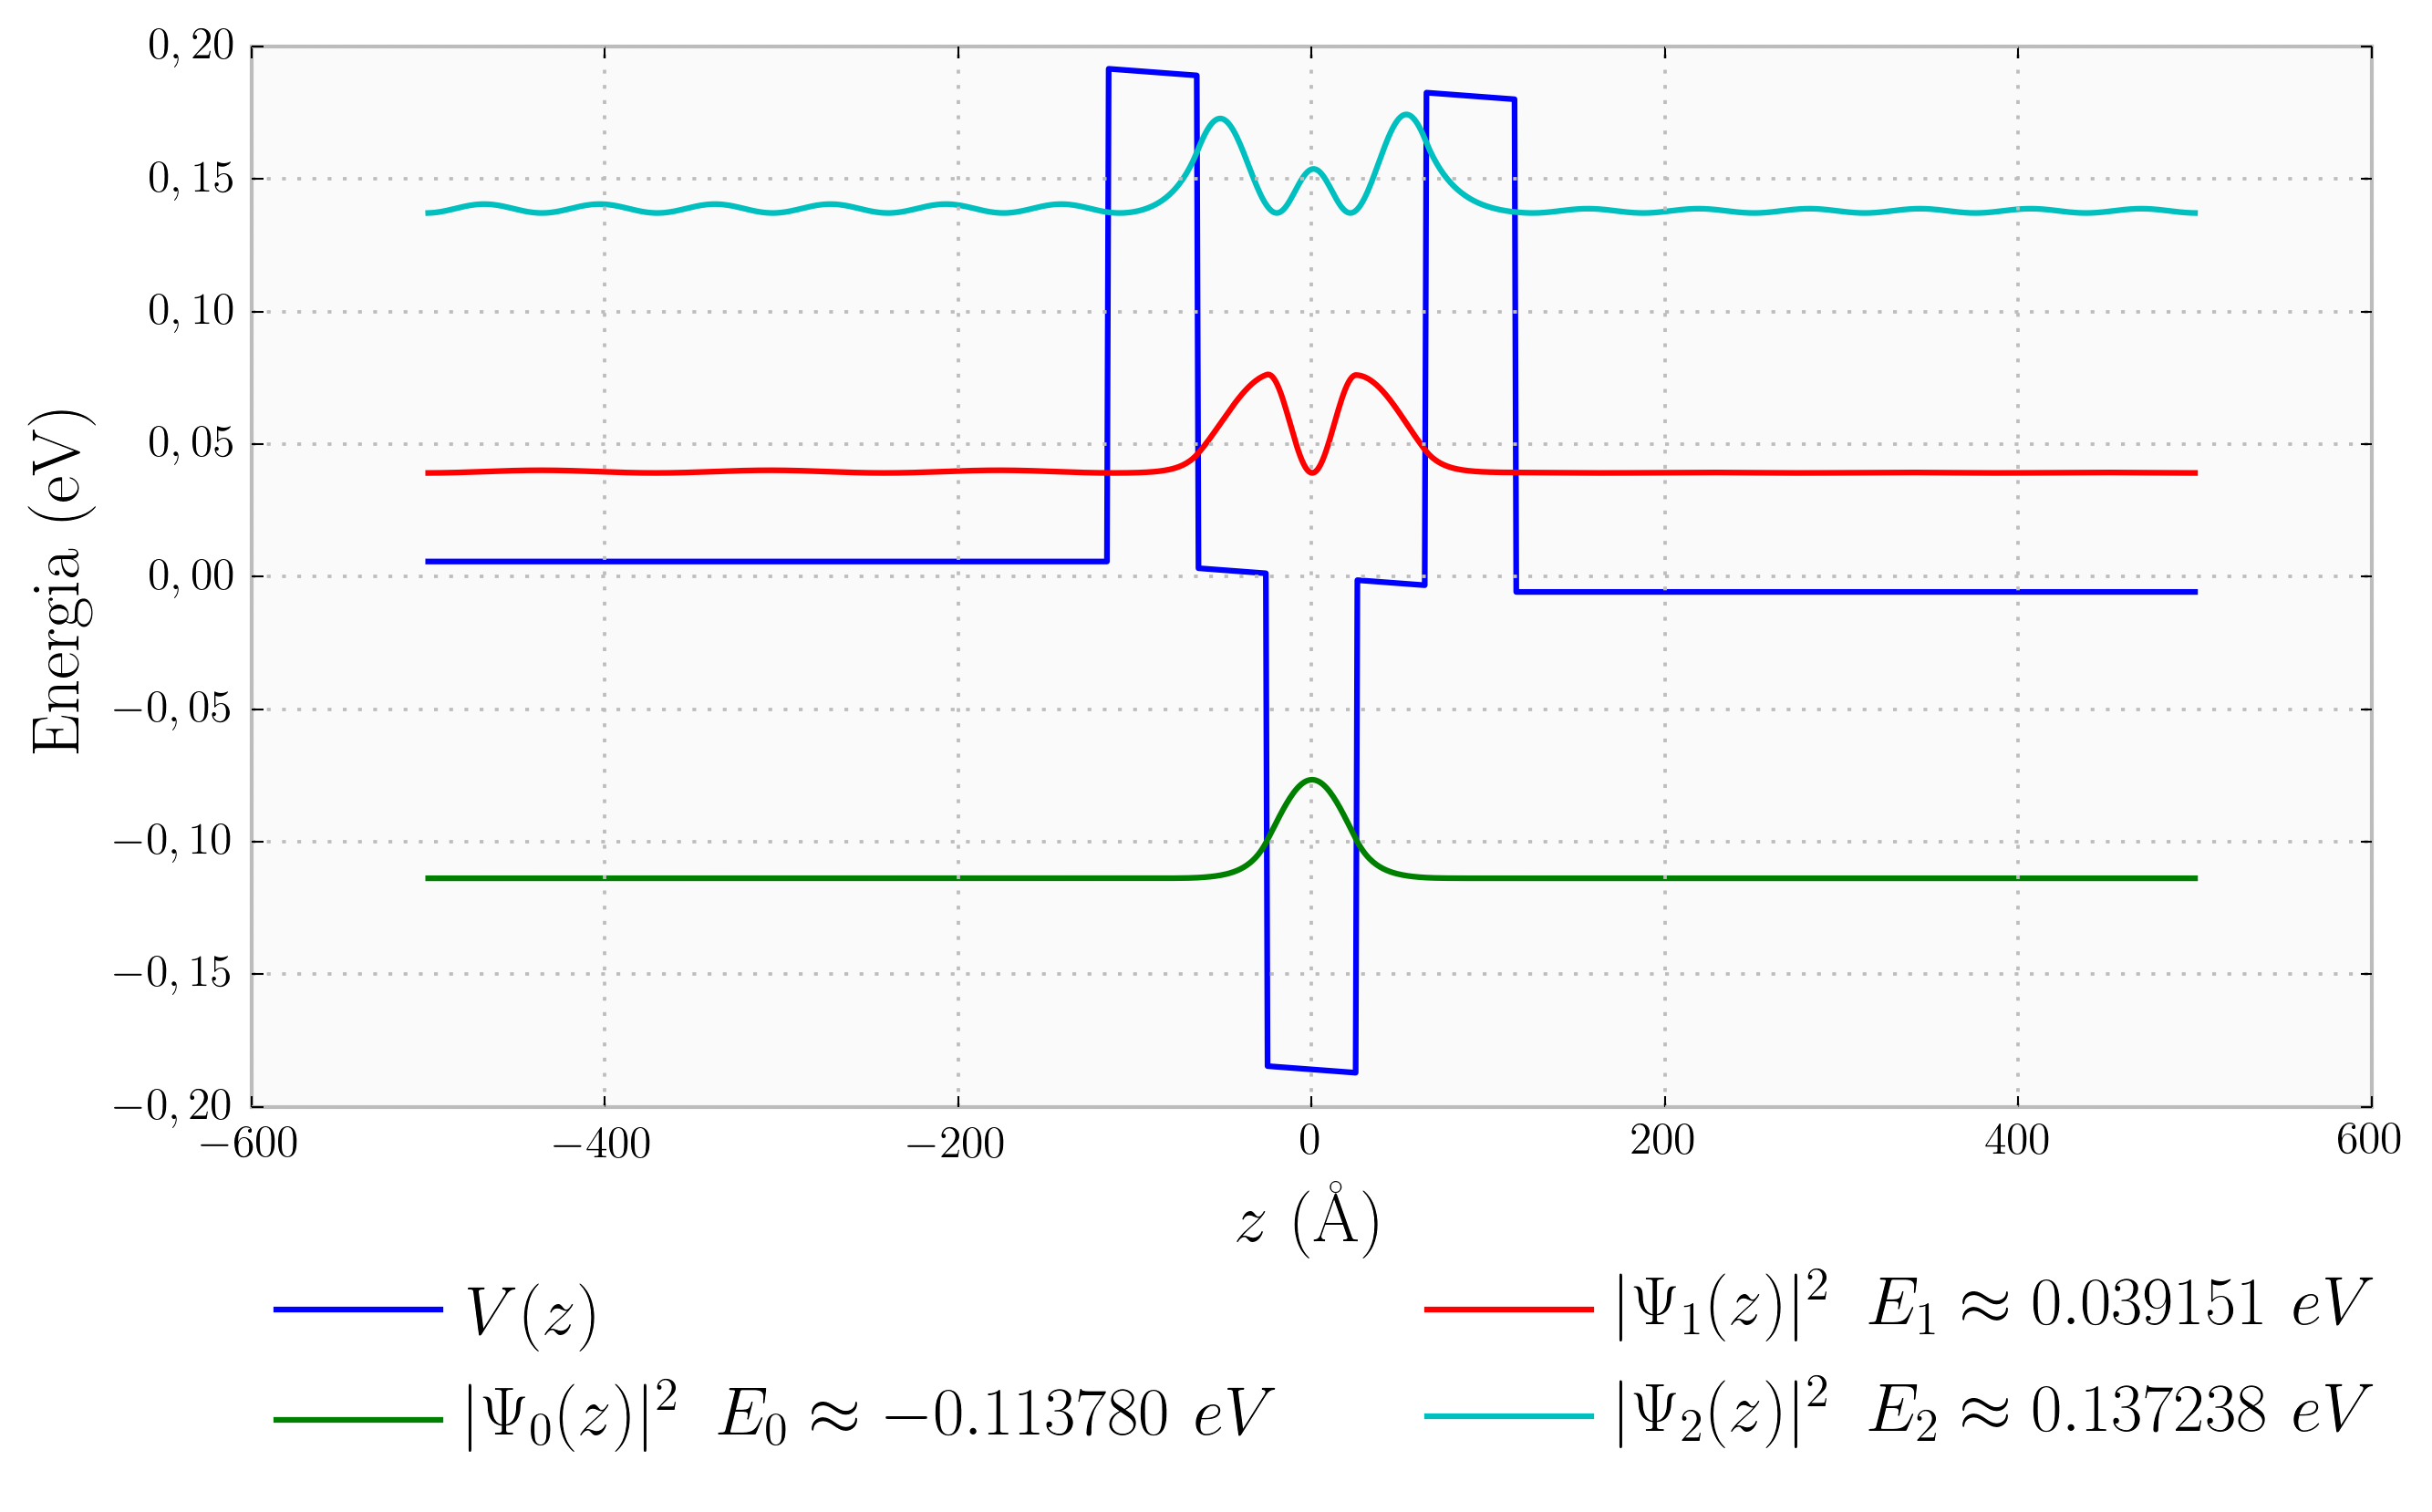

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
ax.plot(device.z_ang, device.v_st_ev, label=r'$V(z)$')

for i, state in enumerate(res["autovetores"]):
    _eivenvalue = res["autovalores"][i] * au2ev
    psi = np.abs(state)**2
    psi *= vpp / np.ptp(psi) / 10
    psi = (psi).real + _eivenvalue    
    ax.plot(device.z_ang, psi, label=r'$|\Psi_%d(z)|^2 \,\,\, E_%d \approx %.6f \,\, eV$' % (i, i, _eivenvalue))

ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
plt.savefig('figuras/double_barrier_quantum_well_degani.png', bbox_inches='tight')

## Potencial absorvedor

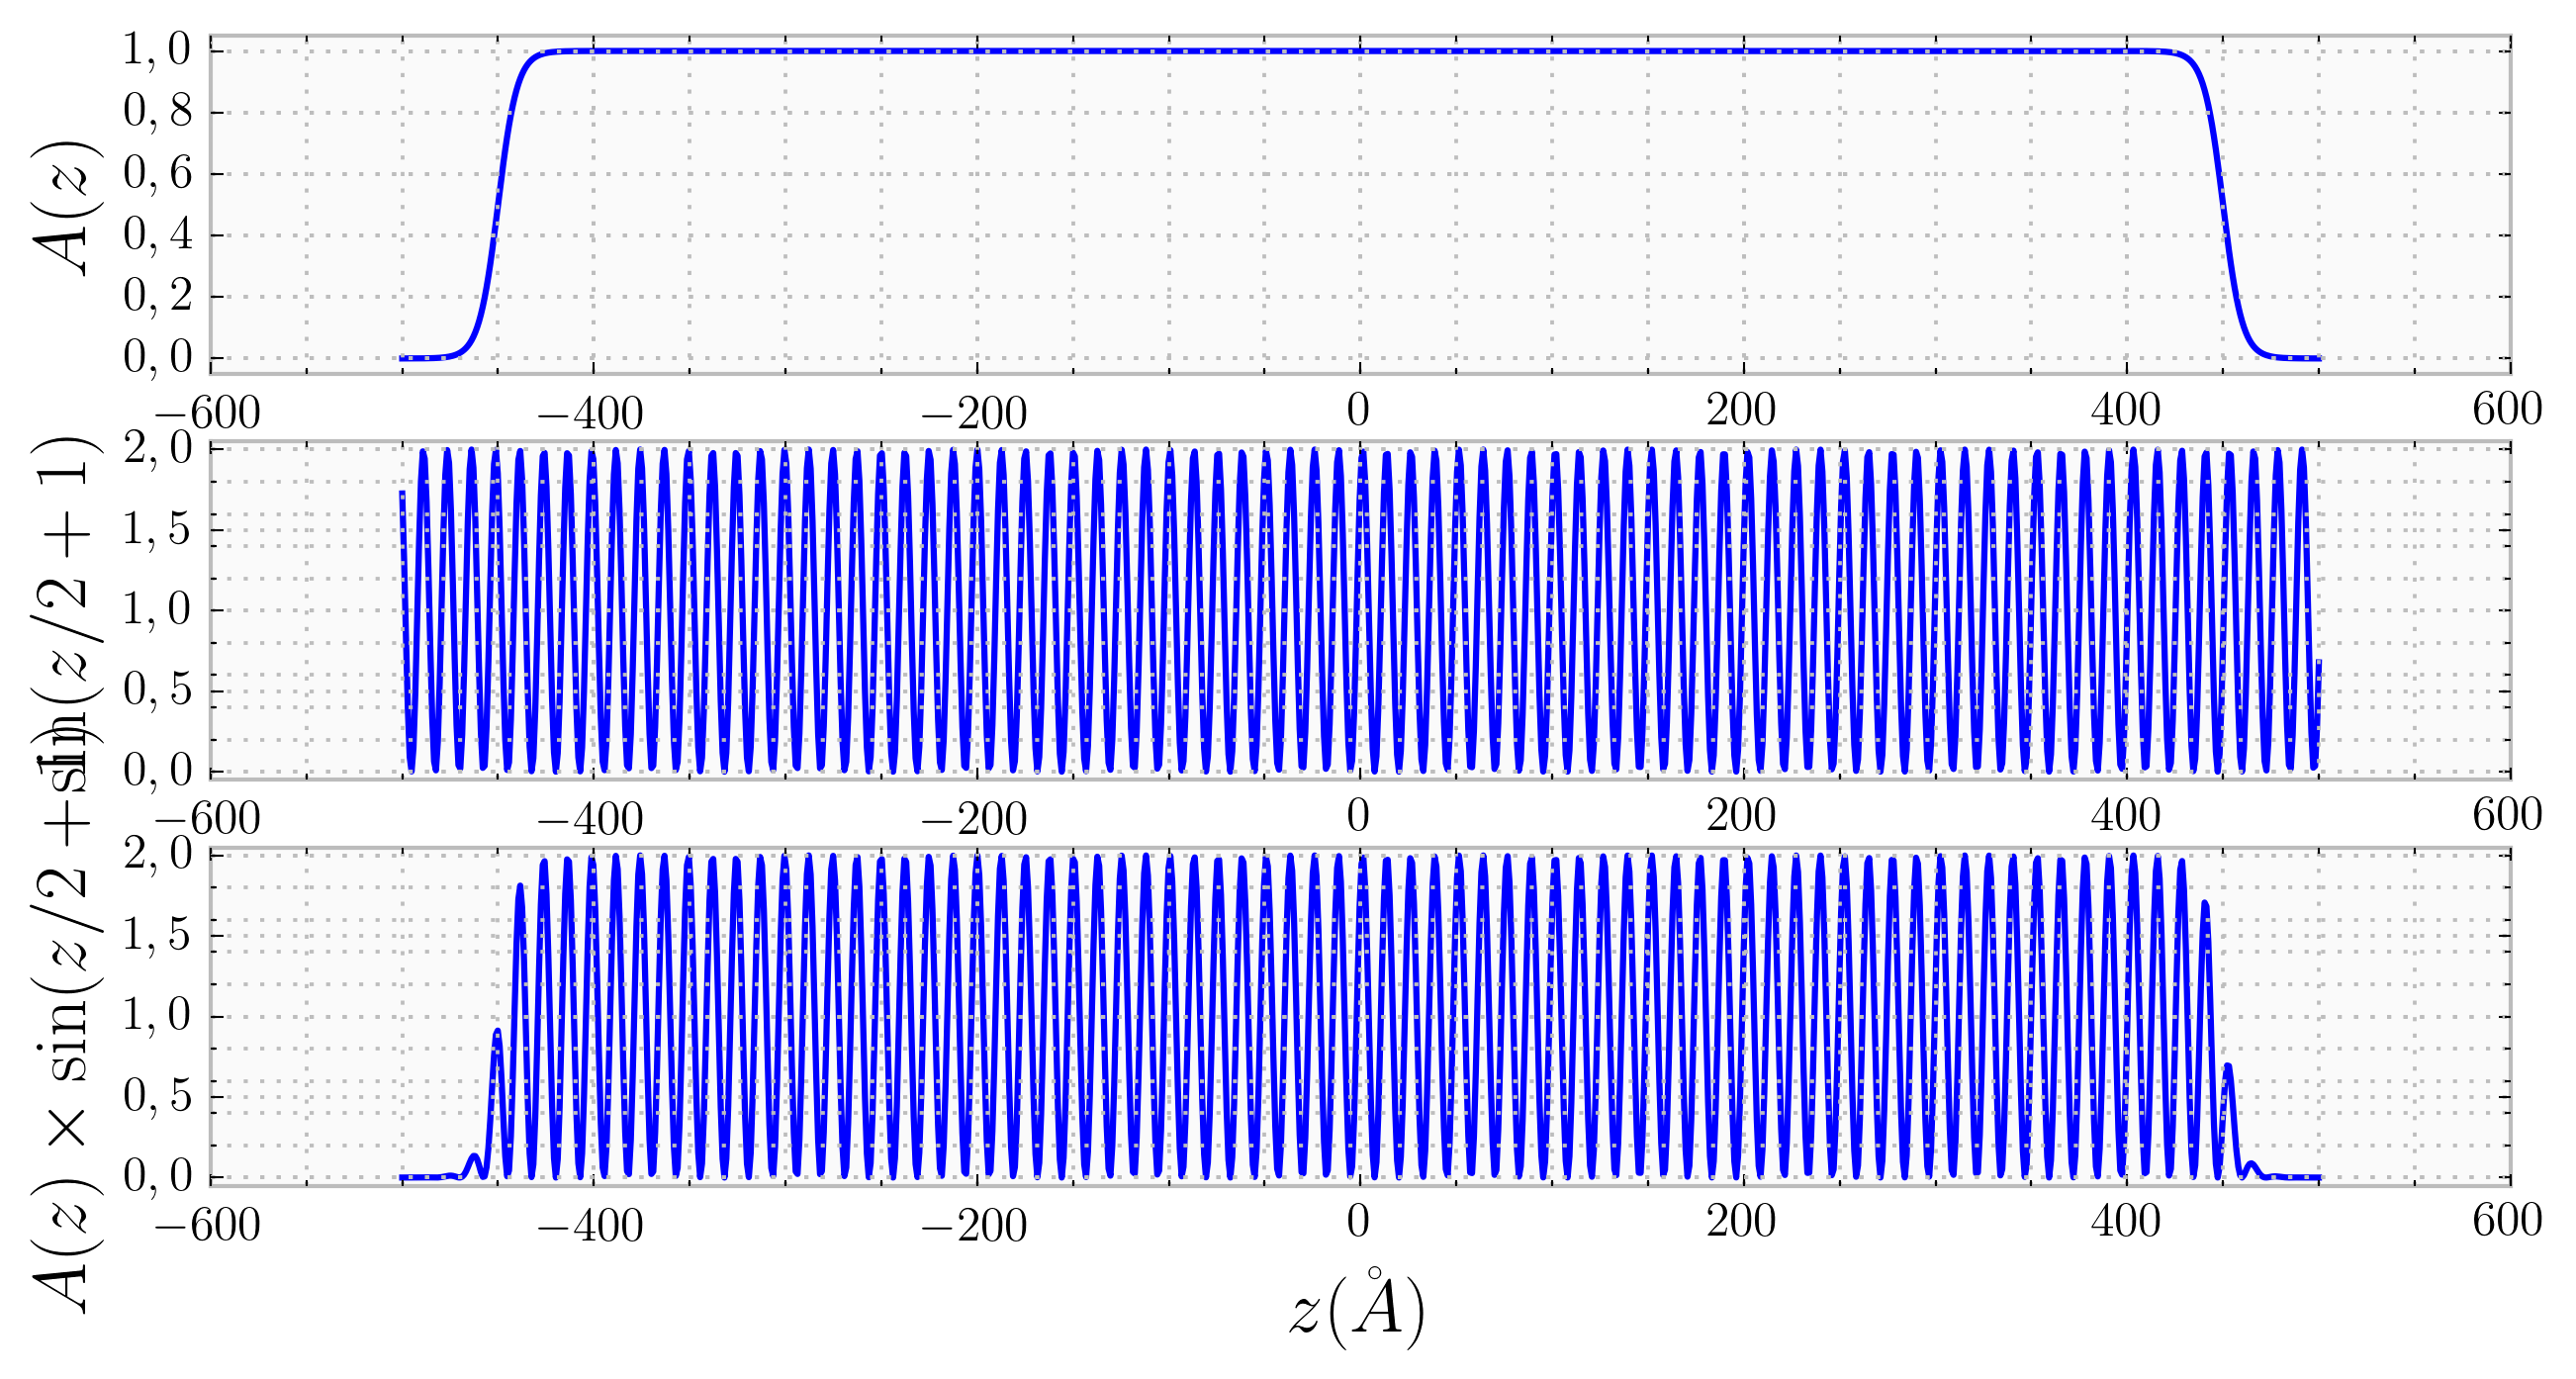

In [8]:
L = 1000.0
N = 1024
z = np.linspace(-L/2,L/2,N)
killer = np.array([min(l,r) for l,r in zip(expit((450-z)/5), expit((z+450)/5))])
to_kill = (1+np.sin(z/2+1))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.set_xlabel(r'$z (\AA)$')
ax1.set_ylabel(r'$A(z)$')
ax1.plot(z, killer)
ax1.xaxis.set_minor_locator(MultipleLocator(50))
ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax1.set_ylim([-0.05, 1.05])
ax1.grid(which = 'minor')

ax2.set_xlabel(r'$z (\AA)$')
ax2.set_ylabel(r'$\sin(z/2+1)$')
ax2.plot(z, to_kill)
ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(0.2))
ax2.set_ylim([-0.05, 2.05])
ax2.grid(which = 'minor')

ax3.set_xlabel(r'$z (\AA)$')
ax3.set_ylabel(r'$A(z) \times \sin(z/2+1)$')
ax3.plot(z, killer*to_kill)
ax3.xaxis.set_minor_locator(MultipleLocator(50))
ax3.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3.set_ylim([-0.05, 2.05])
ax3.grid(which = 'minor')


#plt.show()
plt.savefig('figuras/absorvedor_exemplo.png', bbox_inches='tight')

# Fotocorrente

In [10]:
def fotocorrente(energy:float, fosc:float=5.0, T:float=1e-12)->float:
    """Calcula a fotocorrente para uma dada energia em eV (do campo eletrico)

    Parâmetros
    ----------

    energy : float
        energia dos fotons incidentes em eV
    fosc : float
        intensidade do potencial oscilante em KV/cm
    T : float
        tempo total de evolucao em segundos

    Retorno
    -------

    A fotocorrente 
    """

    fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
    T_au = T / au_t
    iters = int(T_au / dt_au)
    t_grid_au = np.linspace(0.0, T_au, iters)

    psi, _ = normaliza(device.z_au, device.state_0)

    meff = device['meff'].values
    z_au = device['z_au'].values
    dz_au = z_au[1]-z_au[0]
    k_au = fftfreq(N, d=dz_au)
    j_t = np.zeros(iters)

    def j_p(p):
        """J=1/(2 i m*) (psi* d(psi)/dz - psi d(psi*)/dz) """
        dzp = z_au[p+1]-z_au[p-1]
        pcdp = psi[p].conj() * (psi[p+1]-psi[p-1]) / dzp
        pdpc = psi[p] * (psi[p+1].conj()-psi[p-1].conj()) / dzp
        return ((-0.5j/(meff[p])) * (pcdp-pdpc)).real

    absorbing = device['z_ang'].apply(
        lambda z: min(expit((450-z)/5), expit((z+450)/5)))

    z0_ang = device['z_ang'].values[0]
    fosc_j = device['z_ang'].apply(lambda z: (z0_ang-z) * 1e-10 * fosc_j_m)
    fosc_ev = fosc_j / ev
    fosc_au = fosc_ev / au2ev

    omega_au = (energy / au2ev) / hbar_au
    v_au_ti = device['v_au'].values
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / meff)
    exp_v2h = np.exp(- 0.5j * v_au_ti * dt_au)
    f_espec = - 0.5j * fosc_au * dt_au

    for i, t_au in enumerate(t_grid_au):
        exp_v2 = exp_v2h * np.exp(f_espec * np.sin(omega_au*t_au))
        psi = exp_v2 * ifft(exp_t * fft(exp_v2 * psi)) * absorbing
        j_t[i] = j_p(pb-100)-j_p(pa+100)
    return q * (simps(j_t, t_grid_au) / T_au) / T

In [ ]:
energies = np.linspace(0.1, 0.4, 300) # energy from 100 meV to 400 meV
photocurrent = []
def get_pc(energy):
    pc = fotocorrente(energy=energy)
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print("[%s] > Energy: %.6f eV, PC: %.6e " % (now, energy, pc))
    return pc
pool = Pool(processes=4)
photocurrent = pool.map(get_pc, energies)
np.savez("saidas/photocurrent", energies, photocurrent)

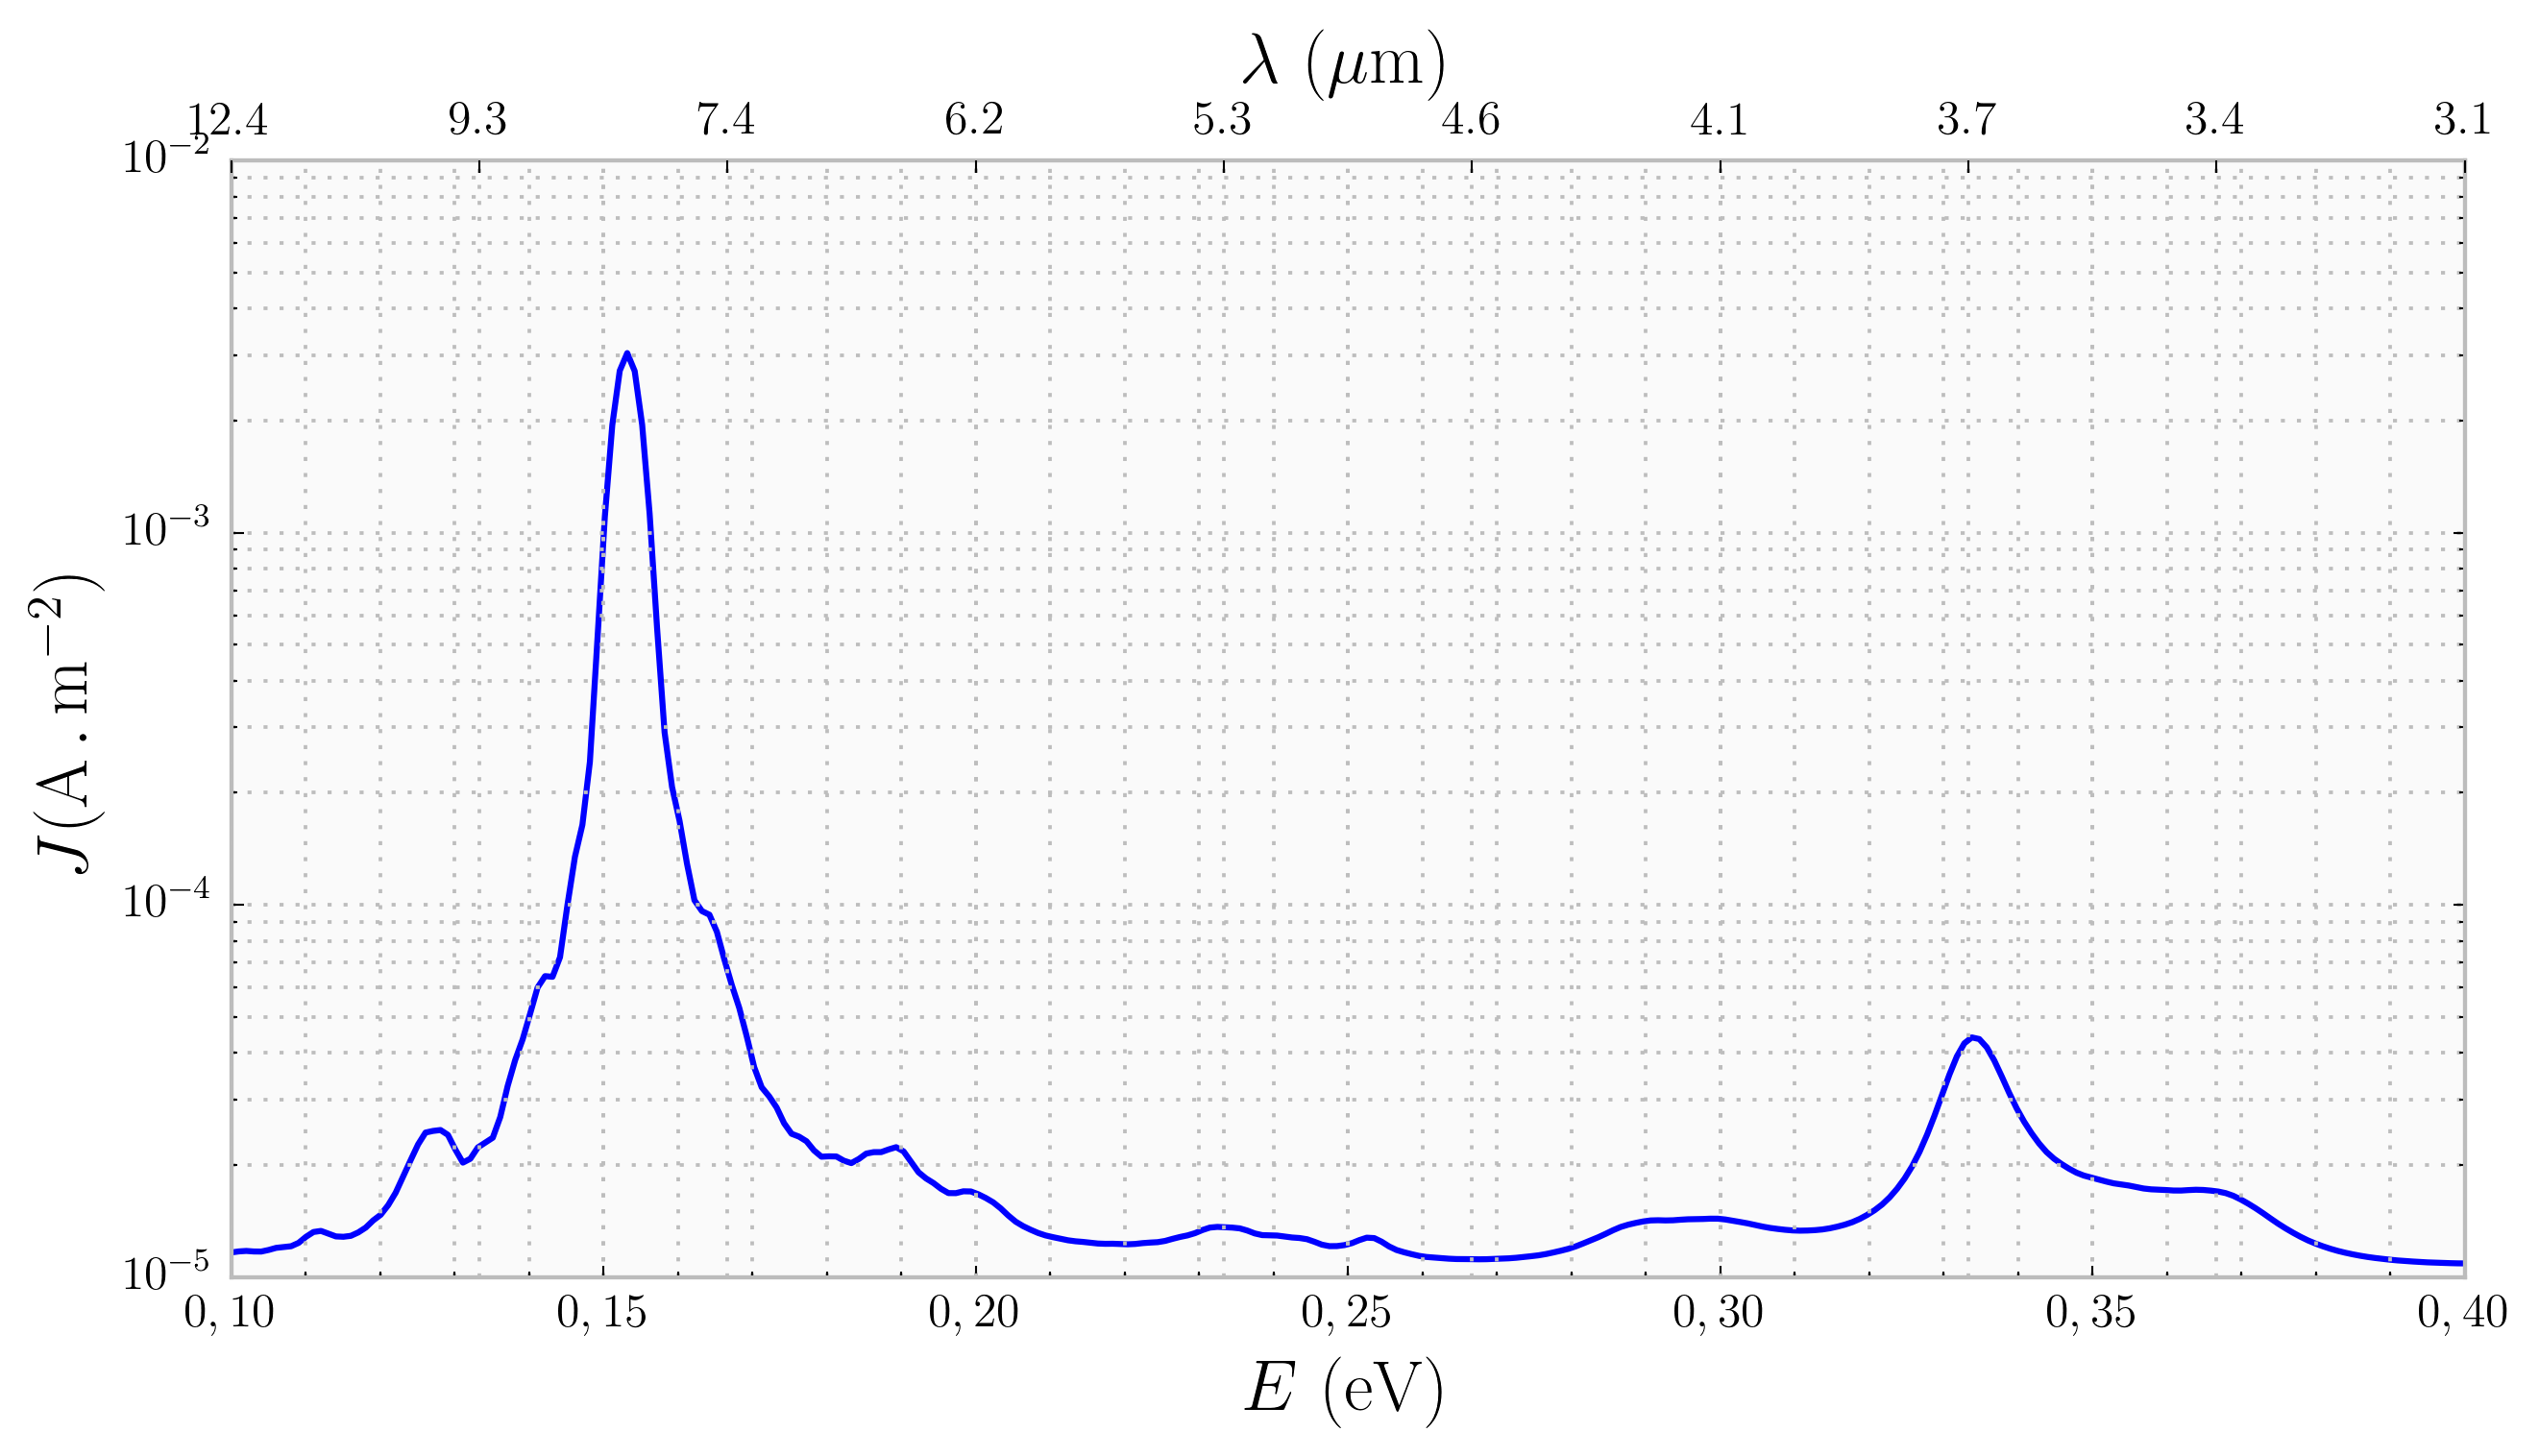

In [9]:
loads = np.load("saidas/photocurrent.npz")
energies, photocurrent = loads['arr_0'], loads['arr_1']

fig, ax = plt.subplots()

ax.set_xlabel(r'$E$ (eV)')
ax.set_ylabel(r'$J (\mathrm{A}\, .\, \mathrm{m}^{-2})$')
ax.semilogy(energies, -np.array(photocurrent)*1e10)

ax2 = ax.twiny()
tiny_energies = np.linspace(0.1, 0.4, 10)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(tiny_energies)
ax2.set_xticklabels(["%.1f" % ((h * c / (e * ev))/1e-6) for e in tiny_energies])
ax2.set_xlabel(r"$\lambda$ ($\mu$m)")

minorLocator_x = MultipleLocator(0.01)
ax.xaxis.set_minor_locator(minorLocator_x)
ax.grid(which = 'minor')
plt.savefig('figuras/fotocorrente_degani.png', bbox_inches='tight')

# Absorção

## Definindo novamente o sistema

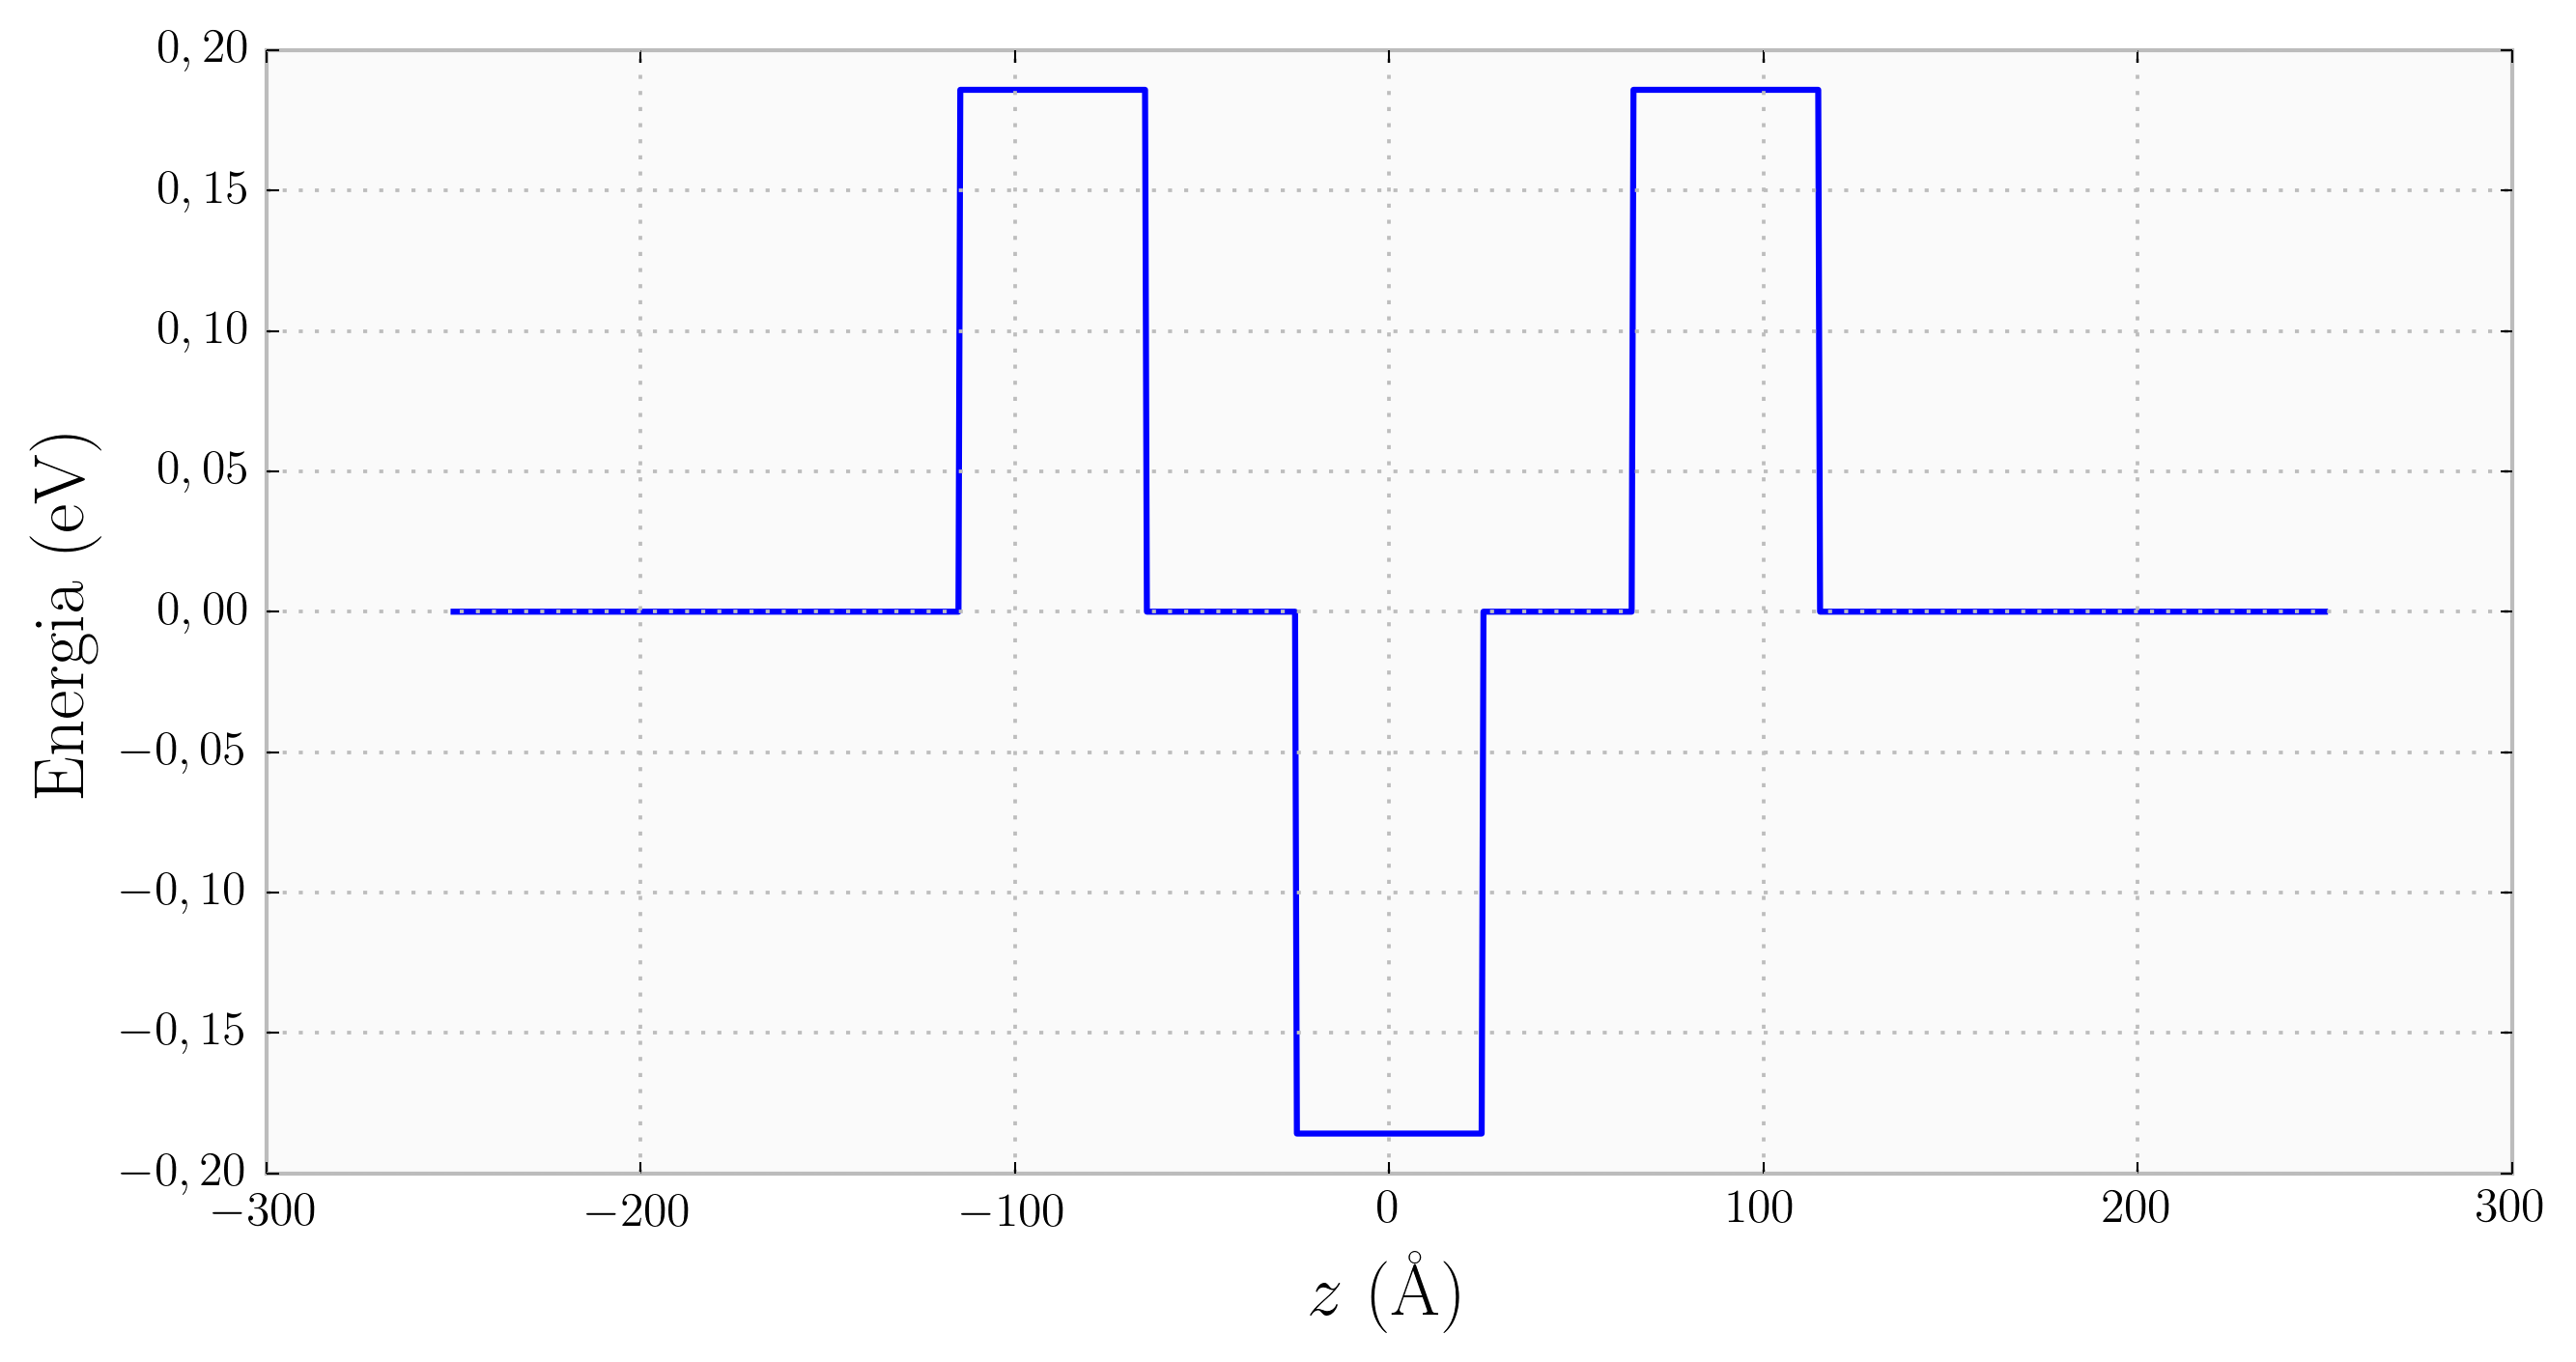

In [10]:
N = 1024  # tamanho padrao do grid
L = 500.0  # tamanho padrao do sistema em angstrom
dt = 1e-17  # incremento de tempo padrao em segundos
dt_au = dt / au_t  # incremento de tempo padrao em unidades atômicas

# dataframe de pandas com valores utilizados para calculos
device = pd.DataFrame()
device['z_ang'] = np.linspace(-L/2, L/2, N)  # malha espacial em angstrom
device['z_au'] = device['z_ang'].apply(lambda z: z / au2ang)
device['x'] = device['z_ang'].apply(x_shape)
device['v_ev'] = device['x'].apply(algaas_gap)
device['meff'] = device['x'].apply(algaas_meff)

pb = list(device['v_ev']).index(0.185897)  # pontos antes do dispositivo
pa = N-1-pb  # pontos depois do dispositivo

# não precisa de bias
bias = 0.0
bias_v_cm = bias * 1e3
bias_v_m = 1e2 * bias_v_cm
bias_j_m = bias_v_m * q

# mas precisa de campo elétrico
fosc = 5.0 # KV/cm
fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
fosc_au = fosc_j_m / au_ef
z_au = device.z_au
Hpo = z_au * fosc_au


def __constroi_bias(z):
    """
    constroi o potencial estatico usado como bias/vies
    NÃO USAR FORA DESTA CÉLULA
    """
    border_left = device['z_ang'].values[pb]
    border_right = device['z_ang'].values[pa]

    def f_st_ev(z): return -(z*1e-10)*(bias_j_m)/ev

    if z <= border_left:
        return f_st_ev(border_left)
    elif z >= border_right:
        return f_st_ev(border_right)
    return f_st_ev(z)

device['bias_ev'] = device['z_ang'].apply(__constroi_bias)
device['v_st_ev'] = device['v_ev']+device['bias_ev']
device['v_au'] = device['v_st_ev'].apply(lambda z: z / au2ev)


fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
ax.plot(device.z_ang, device.v_st_ev)
plt.savefig('figuras/absorcao_potencial_poco_dupla_barreira_com_bias.png', bbox_inches='tight')

## Calculando Autovalores e Autovetores

In [11]:
z = device.z_au.values
V = device.v_au.values
m = device.meff.values
vpp = np.ptp(device.v_ev)
res = interacao_inversa(z, V, m)

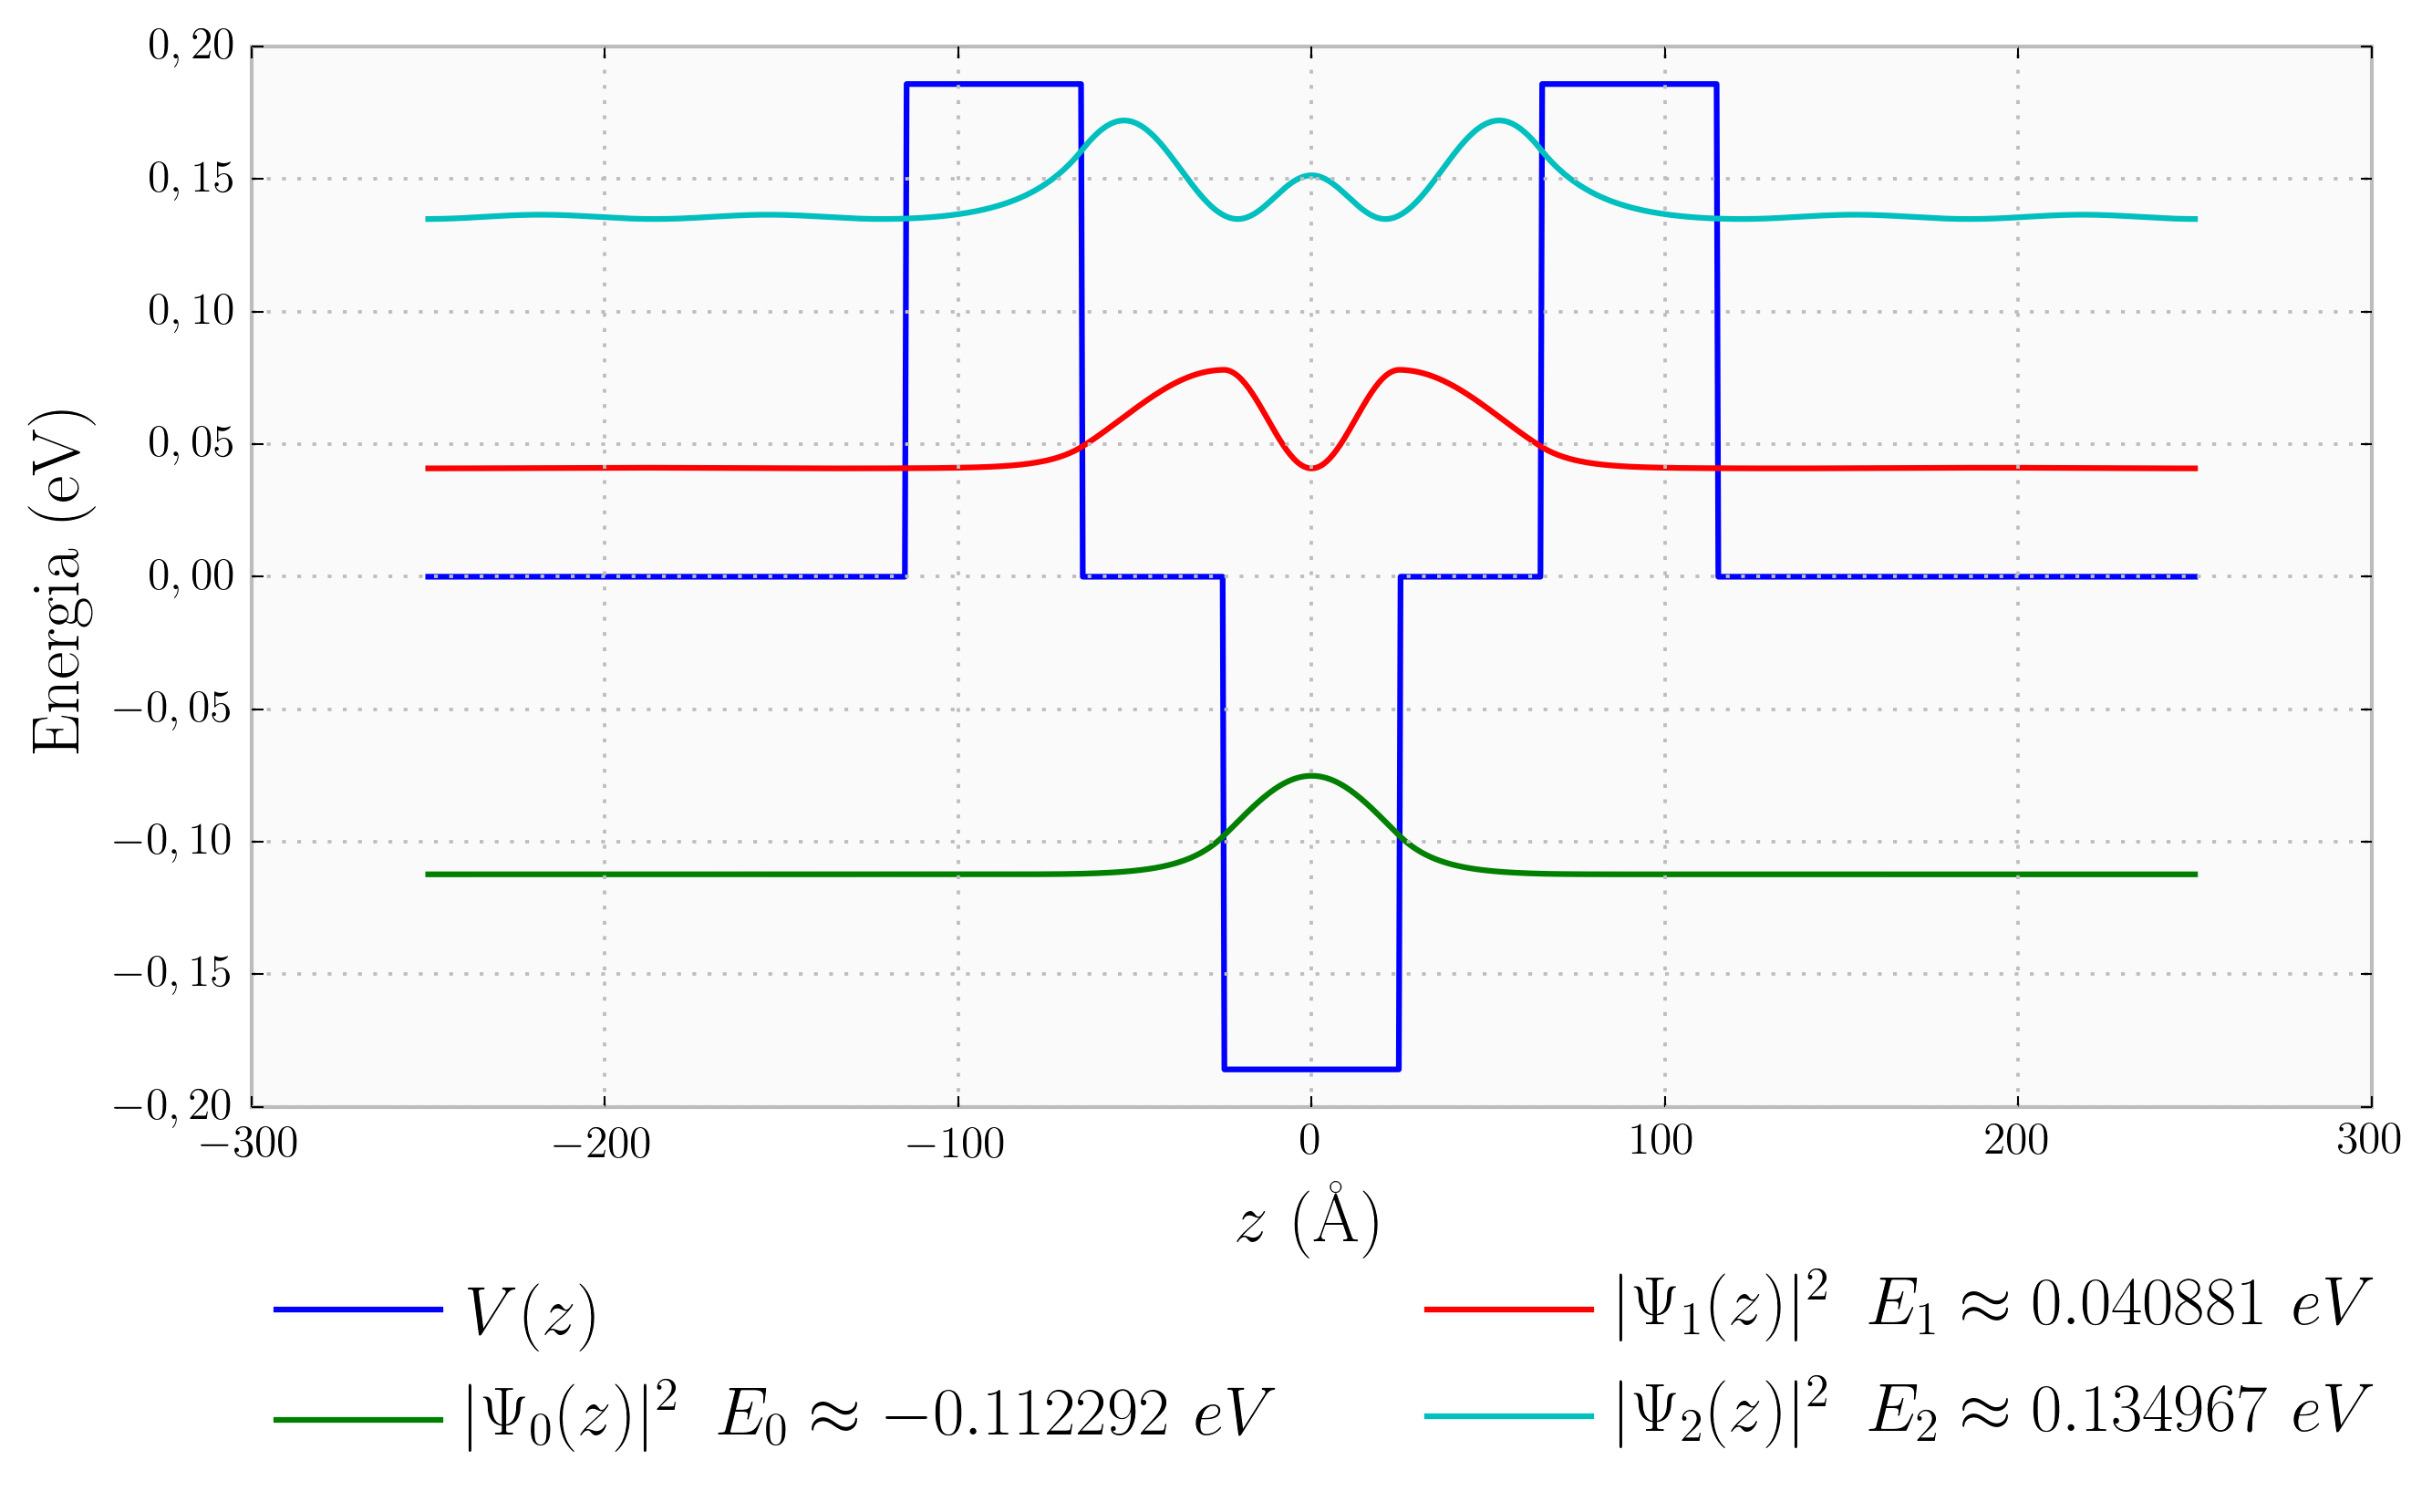

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
ax.plot(device.z_ang, device.v_st_ev, label=r'$V(z)$')

for i, state in enumerate(res["autovetores"]):
    _eivenvalue = res["autovalores"][i] * au2ev
    psi = np.abs(state)**2
    psi *= vpp / np.ptp(psi) / 10
    psi = (psi).real + _eivenvalue    
    ax.plot(device.z_ang, psi, label=r'$|\Psi_%d(z)|^2 \,\,\, E_%d \approx %.6f \,\, eV$' % (i, i, _eivenvalue))

ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
plt.savefig('figuras/double_barrier_quantum_well_degani_sem_vies.png', bbox_inches='tight')

## Absorção com regra de ouro de Fermi

In [15]:
z_au = device.z_au.values
eigenstates = res["autovetores"]
eigenvalues = res["autovalores"] * au2ev

psi0 = eigenstates[0].copy()
psi0_au, _ = normaliza(z_au, psi0)
e0_au = eigenvalues[0] / au2ev

psi1 = eigenstates[1].copy()
psi1_au, _ = normaliza(z_au, psi1)
e1_au = eigenvalues[1] / au2ev

psi2 = eigenstates[2].copy()
psi2_au, _ = normaliza(z_au, psi2)
e2_au = eigenvalues[2] / au2ev

w10_au = (e1_au-e0_au) / hbar_au
w20_au = (e2_au-e0_au) / hbar_au

p1_Hpo_p0_au = simps(psi0_au.conj() * Hpo * psi1_au, z_au)
p1_Hpo_p0_au_2 = p1_Hpo_p0_au.conj() * p1_Hpo_p0_au

p2_Hpo_p0_au = simps(psi0_au.conj() * Hpo * psi2_au, z_au)
p2_Hpo_p0_au_2 = p2_Hpo_p0_au.conj() * p2_Hpo_p0_au

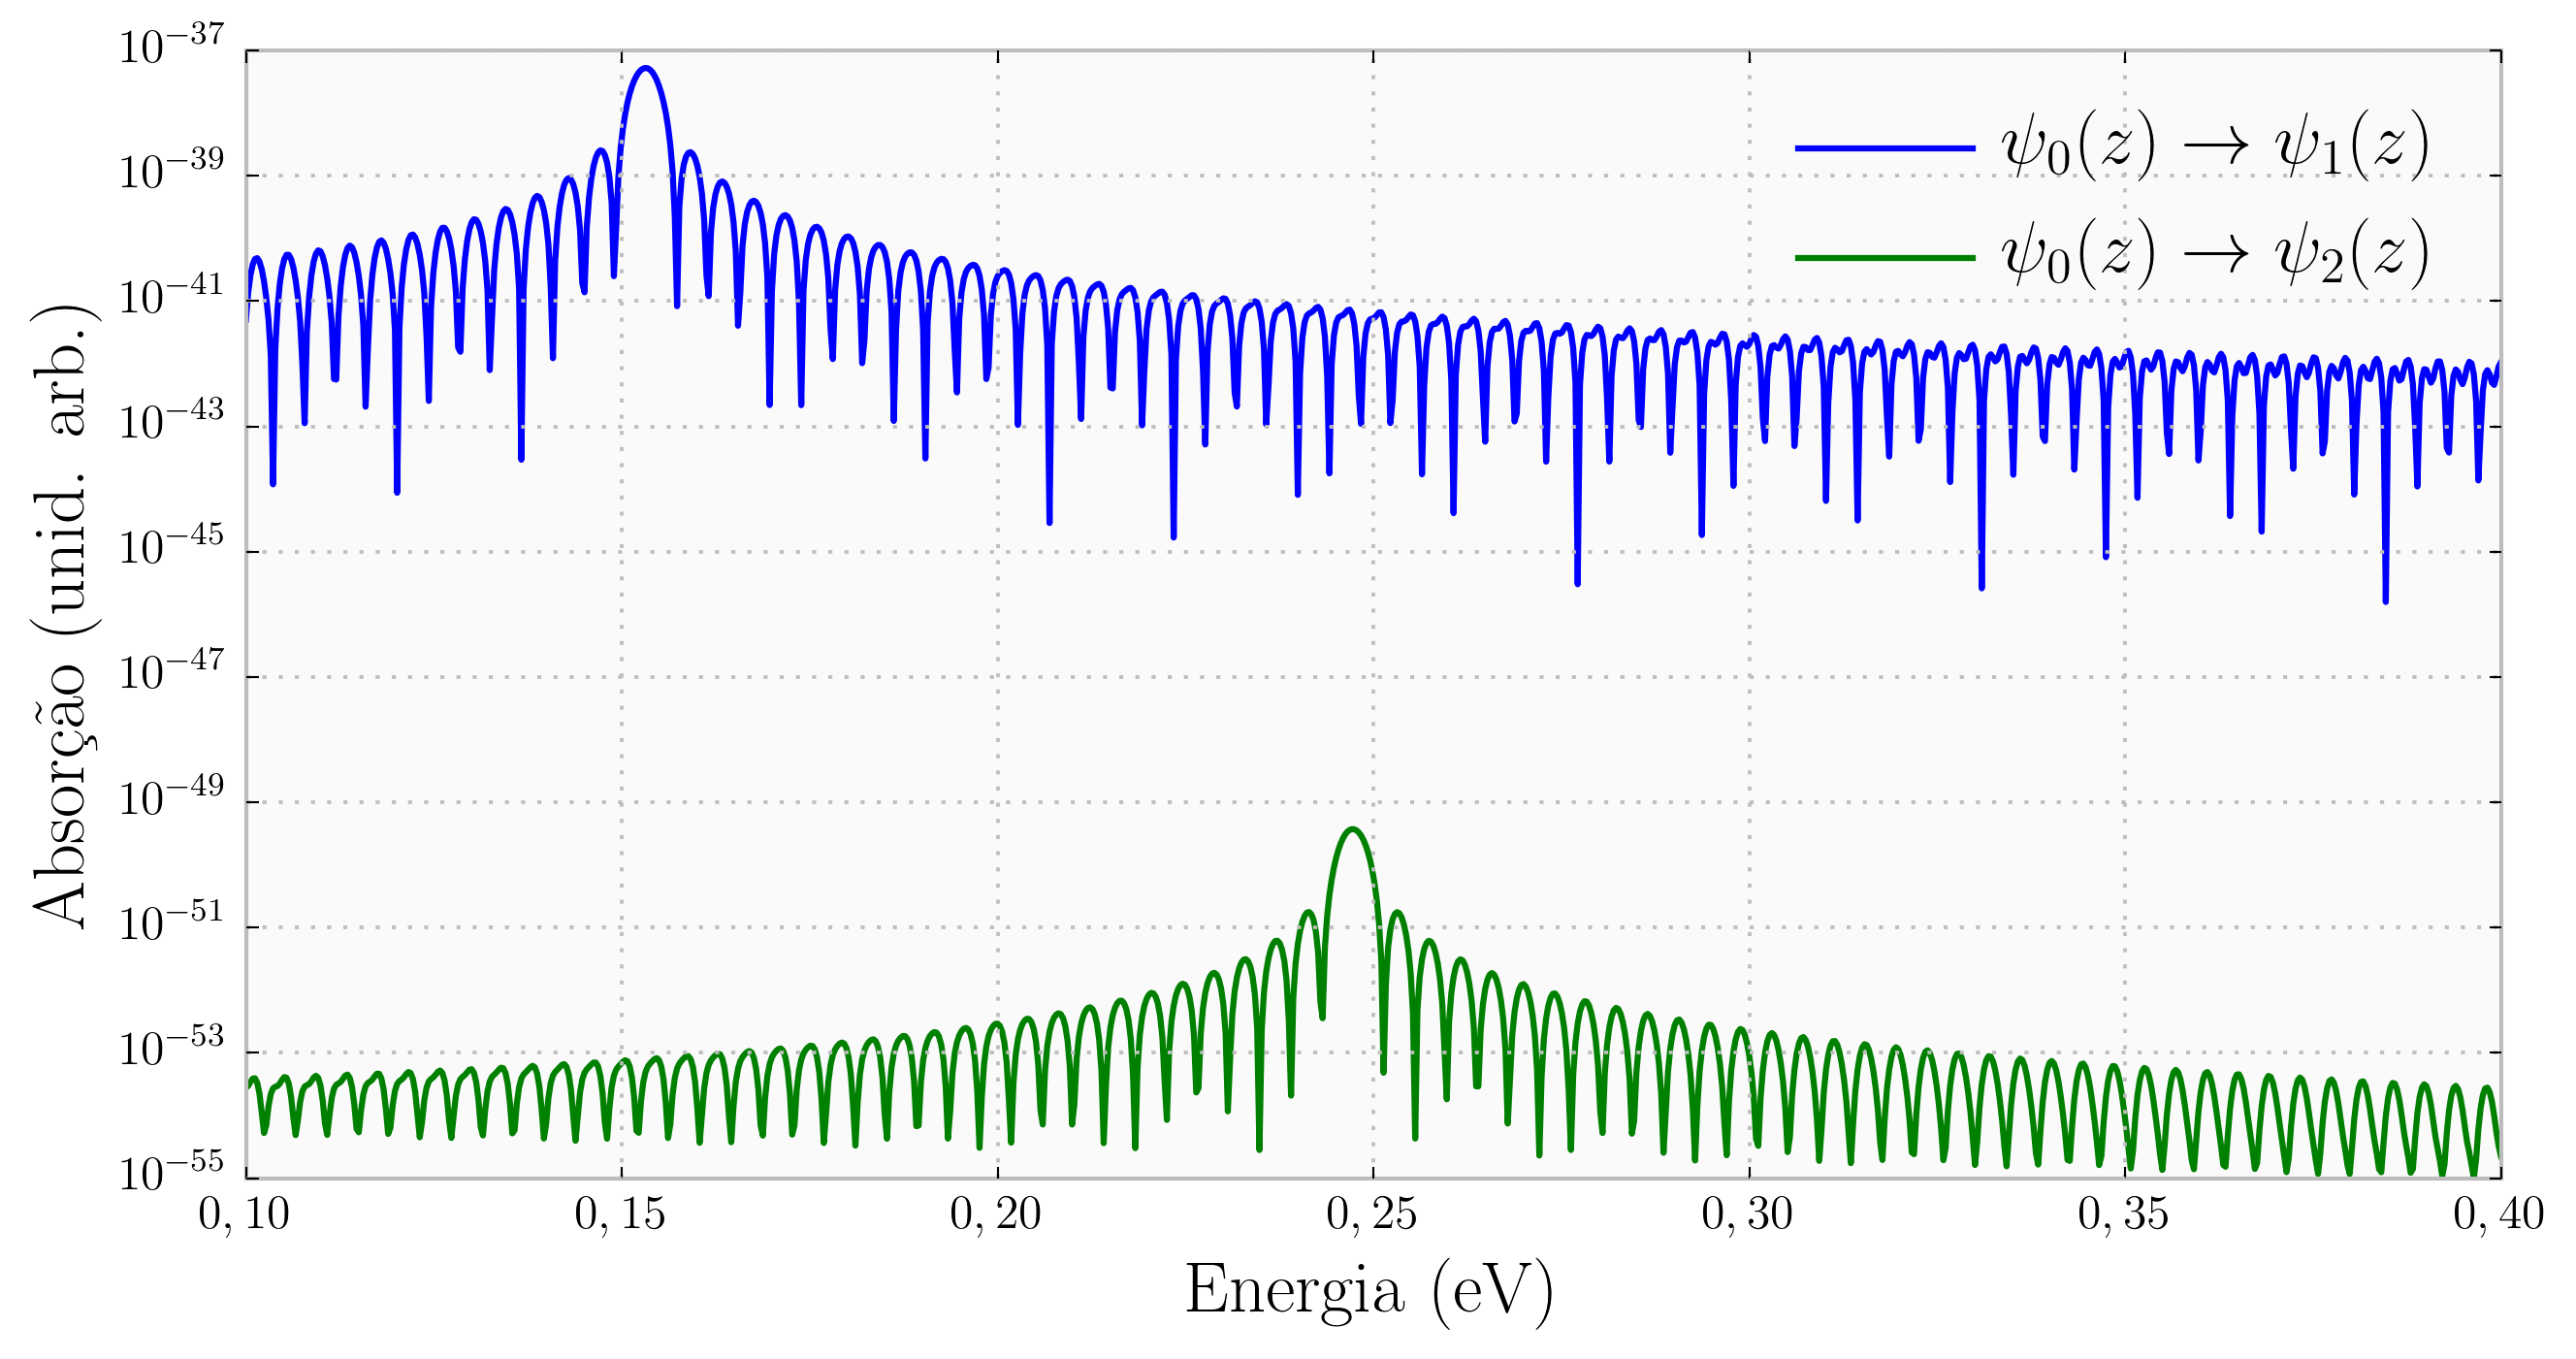

In [18]:
energies = np.linspace(0.1, 0.4, 1000) # ev
energies_au = energies / au2ev
omegas_au = energies_au / hbar_au

t0 = 1e-12
t0_au = t0 / au_t
pcte10 = t0_au**2 * p1_Hpo_p0_au_2
pcte20 = t0_au**2 * p2_Hpo_p0_au_2

def absorption10(w_au):
    a1 = (np.sin((w10_au-w_au)*t0_au/2))/((w10_au-w_au)*t0_au/2)
    a2 = (np.sin((w10_au+w_au)*t0_au/2))/((w10_au+w_au)*t0_au/2)
    a3 = 2.0*np.cos(w_au*t0_au) * a1 * a2
    return (pcte10 * (a1**2+a2**2+a3)).real

def absorption20(w_au):
    a1 = (np.sin((w20_au-w_au)*t0_au/2))/((w20_au-w_au)*t0_au/2)
    a2 = (np.sin((w20_au+w_au)*t0_au/2))/((w20_au+w_au)*t0_au/2)
    a3 = 2.0*np.cos(w_au*t0_au) * a1 * a2
    return (pcte20 * (a1**2+a2**2+a3)).real


fig, ax = plt.subplots()
ax.set_xlabel(r'Energia (eV)')
ax.set_ylabel(r'Absor\c{c}\~{a}o (unid. arb.)')
ax.semilogy(omegas_au*au2ev, np.vectorize(absorption10)(omegas_au).real, label=r'$\psi_0(z) \rightarrow \psi_1(z)$')
ax.semilogy(omegas_au*au2ev, np.vectorize(absorption20)(omegas_au).real, label=r'$\psi_0(z) \rightarrow \psi_2(z)$')
ax.grid(True)
plt.legend()
plt.savefig('figuras/absorcao_poco_dupla_barreira_fermi_golden_rule.png', bbox_inches='tight')

### Absorção com evolução temporal

In [24]:
def absorption_time_evolution(energy, fosc=5.0, T=1e-12):
    fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
    T_au = T / au_t
    iters = int(T_au / dt_au)
    t_grid_au = np.linspace(0.0, T_au, iters)

    meff = device['meff'].values
    z_au = device['z_au'].values
    dz_au = z_au[1]-z_au[0]
    k_au = fftfreq(N, d=dz_au)
    
    d1r = np.zeros(iters)
    d1i = np.zeros(iters)
    d2r = np.zeros(iters)
    d2i = np.zeros(iters)

    psi = np.array(device.state_0, dtype=np.complex_)
    psi /= np.sqrt(simps(psi*psi.conj(), device.z_au))

    psi1 = eigenstates[1].copy()
    psi1_au = psi1 / np.sqrt(simps(psi1.conj()*psi1,z_au))
    e1_au = eigenvalues[1] / au2ev

    psi2 = eigenstates[2].copy()
    psi2_au = psi2 / np.sqrt(simps(psi2.conj()*psi2,z_au))
    e2_au = eigenvalues[2] / au2ev

    absorbing = device['z_ang'].apply(
        lambda z: min(expit((220-z)/3), expit((z+220)/3)))

    z0_ang = device['z_ang'].values[0]
    fosc_j = device['z_ang'].apply(lambda z: (z0_ang-z) * 1e-10 * fosc_j_m)
    fosc_ev = fosc_j / ev
    fosc_au = fosc_ev / au2ev
    omega_au = (energy / au2ev) / hbar_au
    v_au_ti = device['v_au'].values
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / meff)
    exp_v2h = np.exp(- 1.0j * v_au_ti * dt_au)
    f_espec = - 1.0j * fosc_au * dt_au

    psi1_au_c = psi1_au.conj()
    psi1_au_c_Hp = psi1_au_c * (z_au * fosc_j_m / au_ef)
    
    psi2_au_c = psi2_au.conj()
    psi2_au_c_Hp = psi2_au_c * (z_au * fosc_j_m / au_ef)

    for i, t_au in enumerate(t_grid_au):
        exp_v2 = exp_v2h * np.exp(f_espec * np.sin(omega_au*t_au))
        psi = ifft(exp_t * fft(exp_v2 * psi)) * absorbing
        p1 = simps(psi1_au_c_Hp * np.exp(1.0j * e1_au * t_au) * psi, z_au) * \
             simps(psi1_au_c * np.exp(1.0j * e1_au * t_au) * psi, z_au)
        p2 = simps(psi2_au_c_Hp * np.exp(1.0j * e2_au * t_au) * psi, z_au) * \
             simps(psi2_au_c * np.exp(1.0j * e2_au * t_au) * psi, z_au)
        d1i[i] = 2 * (p1).imag
        d1r[i] = 2 * (p1).real
        d2i[i] = 2 * (p2).imag
        d2r[i] = 2 * (p2).real

    abs1 = (simps(d1i*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    abs2 = (simps(d1r*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    abs3 = (simps(d2i*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    abs4 = (simps(d2r*np.cos(omega_au*t_grid_au), t_grid_au) / T_au)
    return abs1, abs2, abs3, abs4

In [9]:
energies = np.linspace(0.1, 0.4, 300) # energy from 100 meV to 400 meV
def get_abs(energy):
    pc = absorption_time_evolution(energy=energy)
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print("[%s] > Energy: %.6f eV, Abs: %.6e " % (now, energy, pc))
    return pc
pool = Pool(processes=4)
absorption_values = pool.map(get_abs, energies)
abs1 = [a[0] for a in absorption_values]
abs2 = [a[1] for a in absorption_values]
abs3 = [a[2] for a in absorption_values]
abs4 = [a[3] for a in absorption_values]
np.savez("saidas/absorption_1_cos_j", energies, abs1)
np.savez("saidas/absorption_2_cos_j", energies, abs2)
np.savez("saidas/absorption_1_cos", energies, abs3)
np.savez("saidas/absorption_2_cos", energies, abs4)

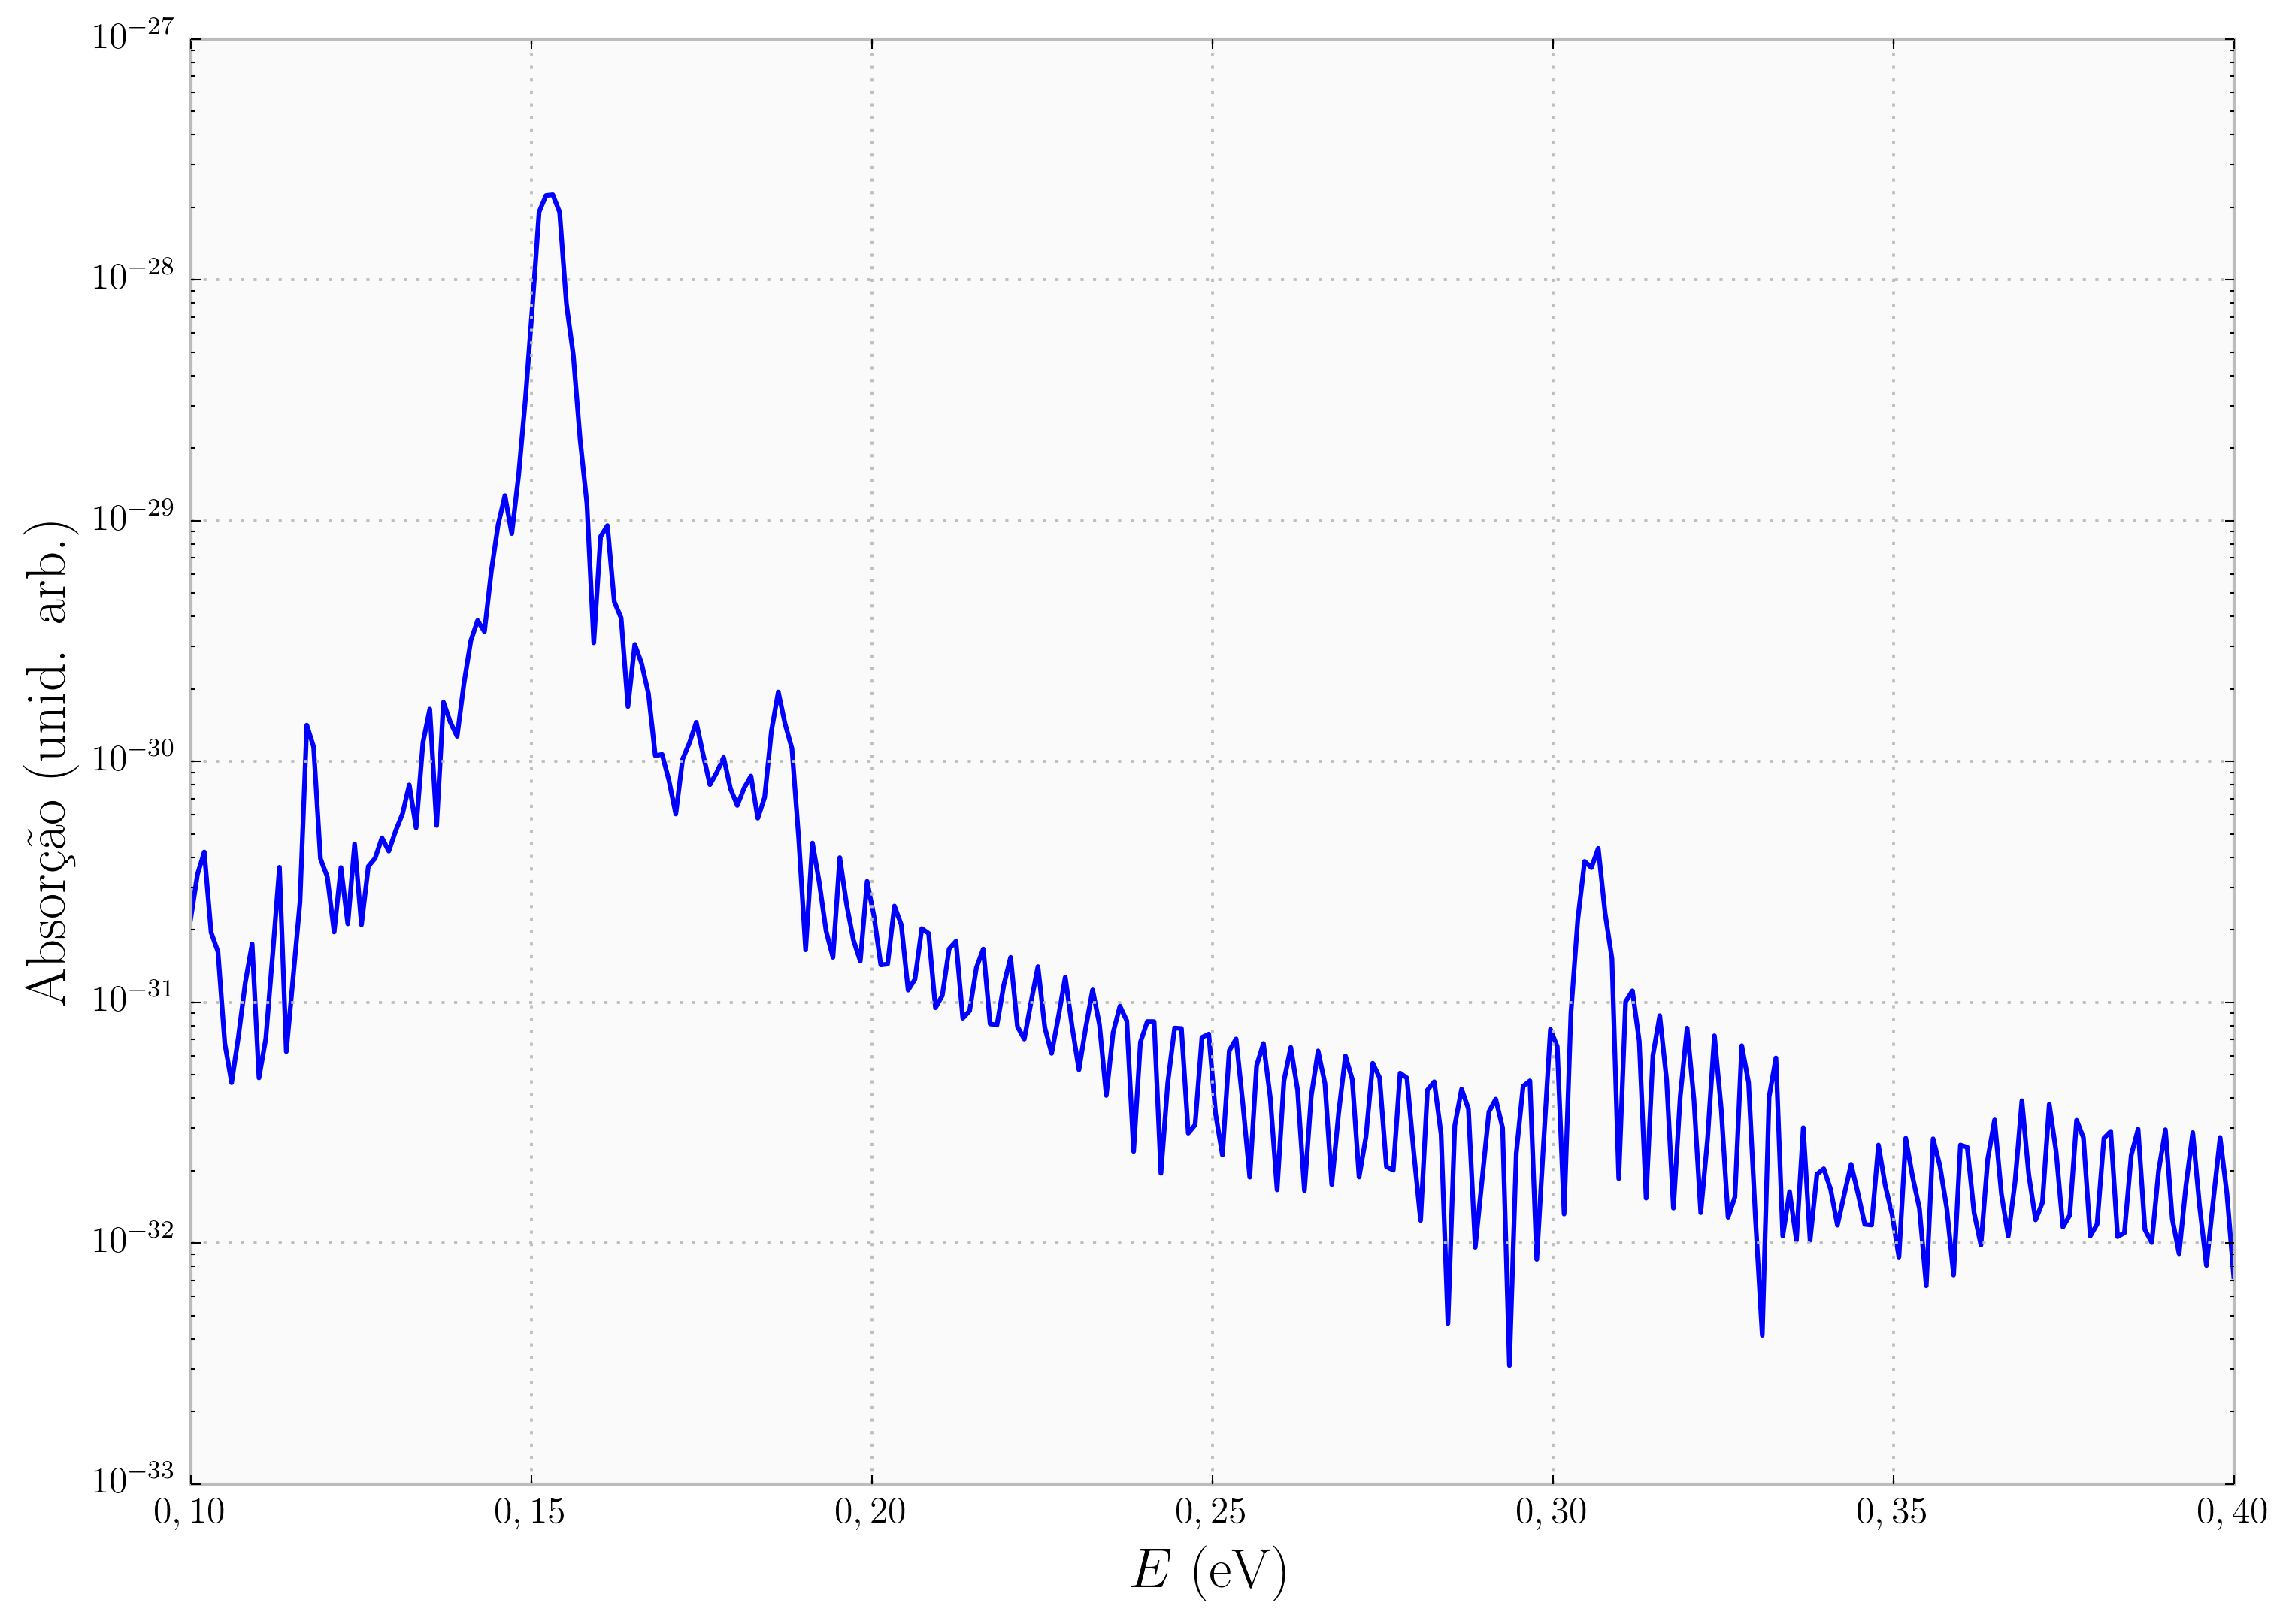

In [12]:
loads1 = np.load("saidas/absorption_1_cos_j.npz")
loads2 = np.load("saidas/absorption_2_cos_j.npz")

energies = loads1['arr_0']
abs1 = loads1['arr_1']
abs2 = loads2['arr_1']

fig, ax = plt.subplots()
ax.set_xlabel(r'$E$ (eV)')
ax.set_ylabel(r'Absor\c{c}\~{a}o (unid. arb.)')
ax.semilogy(energies, energies*(np.abs(abs1)+np.abs(abs2)))
plt.savefig('figuras/absorcao_degani.png', bbox_inches='tight')

In [25]:
df = pd.read_csv('saidas/absorption.csv')

In [26]:
energy = df.energy.values
d1r = df.d1r.values
d2r = df.d2r.values
d1i = df.d1i.values
d2i = df.d2i.values

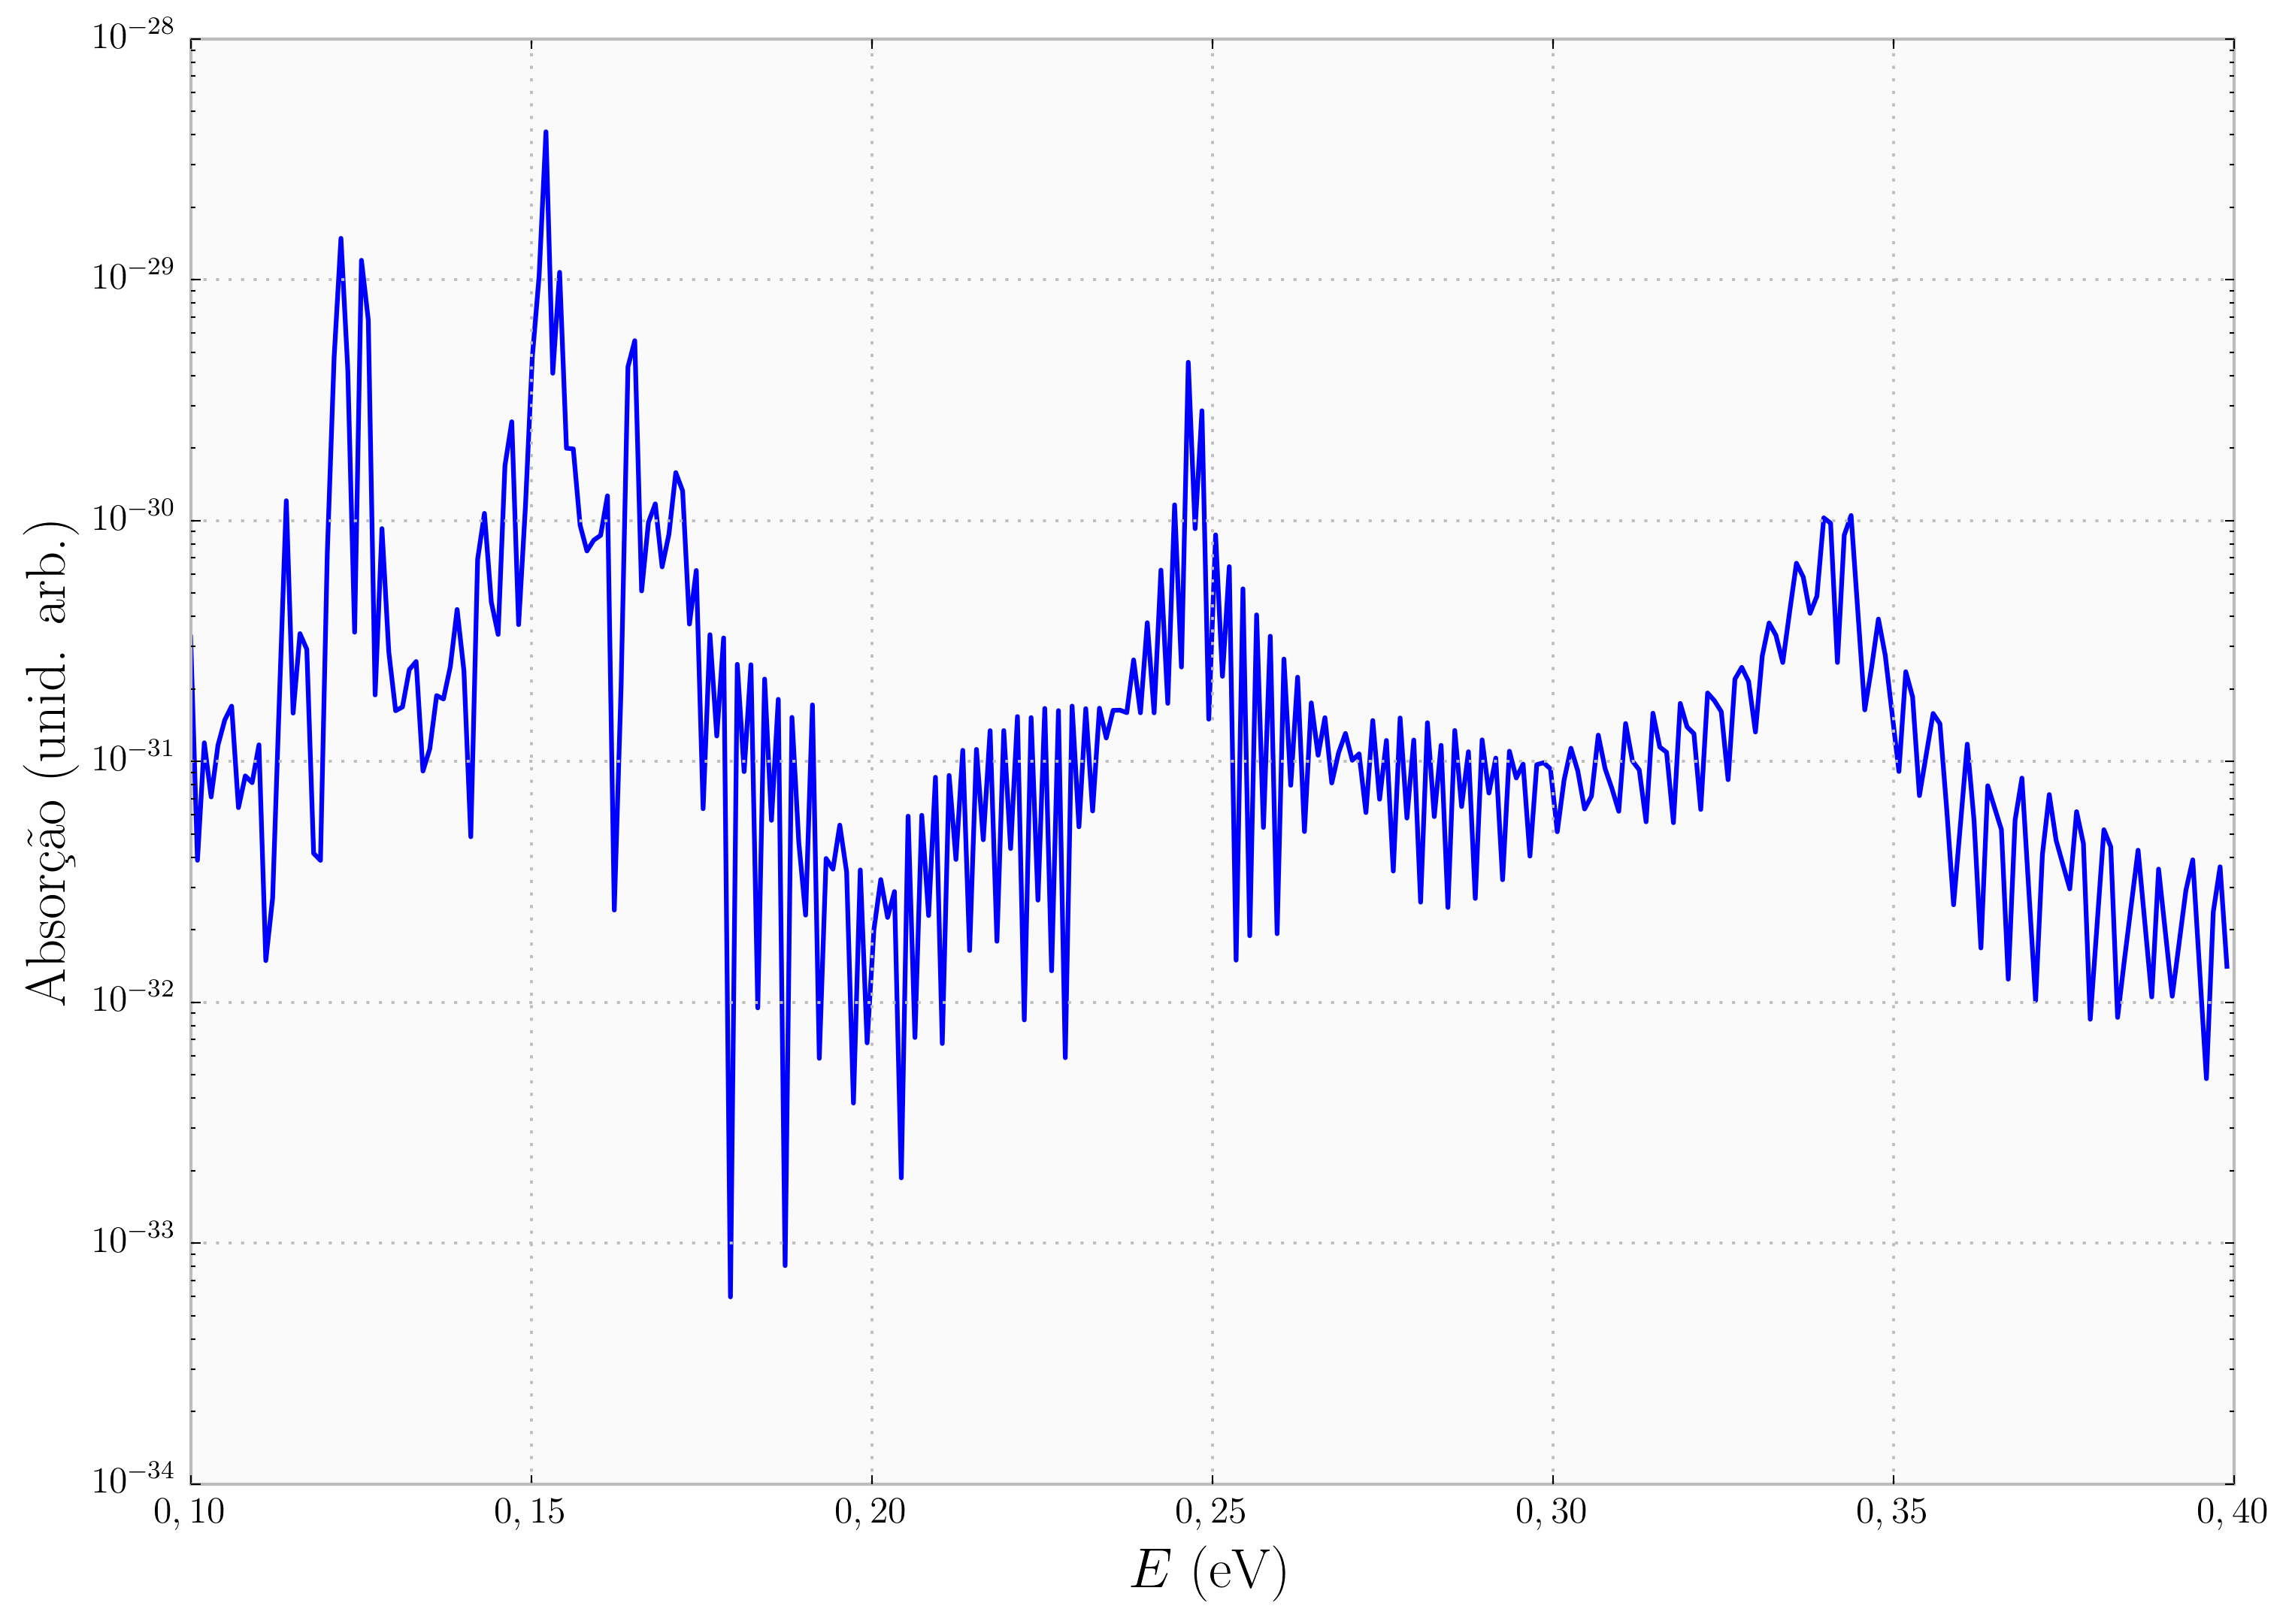

In [28]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$E$ (eV)')
ax.set_ylabel(r'Absor\c{c}\~{a}o (unid. arb.)')
#ax.semilogy(energy, energy*(np.abs(d1i)), label=r'$\psi_0 \rightarrow \psi_1$')
#ax.semilogy(energy, energy*(np.abs(d2i)), label=r'$\psi_0 \rightarrow \psi_2$')
ax.semilogy(energy, energy*(np.abs(d2i)))
#plt.legend()
plt.savefig('figuras/absorcao_degani_2.png', bbox_inches='tight')